**Introduction:** 
The workflow of the autoencoder is as follows,


[1] Import the dataset

[2] Define the place holders

[3] Design the weight vectors(for all the layers of encoder and decoders)

[4] Design the biases(for all the layers of encoder and decoders)

[5] Build the Encoder section

[6] Build the Decoder section

[7] Design/ Define the Loss function 

[8] Design/Define the optimizer 

[9] Design the training process
        (a)Train the network
        (b)Test the network (with test sets)
        (c)Display the reconstructed image(also the original test image)



**Architechture of the AutoEncoder:**

Here we will design a convolutional neural network for the AutoEncoder. The structure of the neural network will be as follows:


 The Architecture of the AutoEncoder:

    · · · · · · · · · ·   -- I (input data, 1-deep) X [batch, 28, 28, 1]
 
    @ @ @ @ @ @ @ @ @ @   -- 1st Encoder conv. layer of: 10x10x1=>10 stride 1,SAME Padding WE1[10, 10, 1, 10],B1[10]
                              Note: All Convolution Layers will be activated with Relu
    \/\/\/\/\/\/\/\/\/    -- Max pool with kernal[1,2,2,1] and stride [1,2,2,1], SAME Padding                        
    ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶   -- E1 [batch, 14, 14, 10](This is the output of the 1st Encoder convolution layer)
    
      @ @ @ @ @ @ @ @     -- 2nd Encoder conv. layer of: 5x5x10=>10 stride 1,SAME Padding WE2 [5, 5, 10, 10],B2[10]
      \/\/\/\/\/\/\/      -- Max pool with kernal[1,2,2,1] and stride [1,2,2,1], SAME Padding
      ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶     -- E2 [batch, 7, 7, 10]
      
       
       XXXXXXXXXXX        -- End of Encoder and Start of Decoder, Now for decoding we have to upsample the output
                             using: {upsample1 = tf.image.resize_images(E3, size=(14,14), 
                                                                     method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)}
       ^^^^^^^^^^^        -- U1 Upsampling [Batch, 14, 14, 10]                                                              
       @ @ @ @ @ @        -- 1st Decoder conv. layer of: 5x5x10=>10 stride 1,SAME Padding WD1[5, 5, 10, 10],C1[10] 
                             
      ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶     -- D1 [batch, 14, 14, 10] (This is the output of the 1st Decoder convolution layer)
      ^^^^^^^^^^^^^^^     -- U2 Upsampling of D1 to size [Batch, 28,28, 10] 
    
    @ @ @ @ @ @ @ @ @     -- 2nd Decoder conv.layer of: 10x10x10=>10 stride1,SAME Padding WD2[10, 10, 10, 10],C2[10]
    ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶:::    -- D2 [batch, 10, 10, 10]
    
    ...................   -- Logits ConV. Layer of: 10X10X10=>1 stride 1,SAME Padding, WD3 [10, 10,10,1], C3 [1] 
                            
                             Pass the logits through Sigmoid tf.nn.sigmoid(logits)
Reference: https://medium.com/towards-data-science/autoencoders-introduction-and-implementation-3f40483b0a85 


**Import Dependencies:**

In [1]:
%matplotlib inline
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math


**Preaparing Dataset:**

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
data = read_data_sets("data", one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels))) # here "\t" is for tab
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


**Defining the Weights:**

In [3]:
# Function for declaring weight variable
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
# Here "tf.truncated_normal" function returns the graph random values from a truncated normal distribution with a given standard deviation
# and "tf.Variable" fucntion returns the graph of variables, Here 

**Defining the Biases:**

In [4]:
# Function for declaring Bias variable
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

**Defining the Encoder:**

In [5]:
def new_encod_layer(input,             # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter(or weights).
                   num_filters,        # Number of filters./ or ouput channel
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    # The convolutional layer
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    
    # Add the biases to the results of the convolution.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)

    return layer, weights


**Defining the Decoder:**

In [6]:
def new_decod_layer(input,             # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter(or weights)
                   num_filters,        # Number of filters./ No of output channel
                   upsample_size,      # Upsampling size
                   use_upsampling=True):

  
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)
   
    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
   
    if use_upsampling:
        Upsam=tf.image.resize_images(input, size=(upsample_size,upsample_size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        
    layer = tf.nn.conv2d(input=Upsam,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    layer = tf.nn.relu(layer)
   
    return layer, weights


**Defining Logits Layer:**

In [7]:
def Logits_layer(input,               # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter(or weights).
                   num_filters):      # Number of filters./ or ouput channel

    shape = [filter_size, filter_size, num_input_channels, num_filters]

 
    weights = new_weights(shape=shape)

  
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    return layer, weights

**Defining Input and Target Placeholders:**

In [8]:
input_image = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets') # Original image without noise to evaluate the gradient

**Declaring Encoder layers:**

In [9]:
#First Encoder
#The input has a dimention of 28x28x1
E1, WE1 = new_encod_layer(input=input_image, 
                         num_input_channels=1,# Because input image is gray
                         filter_size=10, # the weight matrix will be of size 10x10
                         num_filters=10, # Number of output channel will be 10
                         use_pooling=True)
#output of the convolutional layer is 14x14x10 since the function max pool and stride at 2x2

In [10]:
#2nd Encoder
#The input has a dimention of 14x14x10
E2, WE2 = new_encod_layer(input=E1, 
                         num_input_channels=10,
                         filter_size=5, # the weight matrix will be of size 10x10
                         num_filters=10, # No of output channel will be 10
                         use_pooling=True)
#output of the convolutional layer is of 7x7x10 since the function max pool and stride at 2x2

**Declaring Decoder Layers:**

In [11]:
# First Decoder
# The input has a dimention of 7X7X10

D1, WD1 = new_decod_layer(input=E2,       # The previous layer.
                   num_input_channels=10, # Num. channels in prev. layer.
                   filter_size=5,         # Width and height of each filter(or weights)
                   num_filters=10,        # Number of filters./ No of output channel
                   upsample_size=14,      # Upsampling size
                   use_upsampling=True) 
#output of the convolutional layer is of 14x14x10 since the function has 14x14 upsampling

In [12]:
# 2nd Decoder
# The input has a dimention of 14X14X10

D2, WD2 = new_decod_layer(input=D1,       # The previous layer.
                   num_input_channels=10, # Num. channels in prev. layer.
                   filter_size=10,         # Width and height of each filter(or weights)
                   num_filters=10,        # Number of filters./ No of output channel
                   upsample_size=28,      # Upsampling size
                   use_upsampling=True) 
#output of the convolutional layer is of 28x28x10 since the function has 14x14 upsampling

**Declaring Logits Layer:**

In [13]:
# The input layer(D2) have a dimention of 28x28x10
Logits_Layer_1, Logits_weights = Logits_layer(input=D2,              # The previous layer.
                                              num_input_channels=10, # Num. channels in prev.(input) layer.
                                              filter_size=10,        # Width and height of each filter(or weights).
                                              num_filters=1)       # Number of filters./ or ouput channel

**Reconstruted Output:**

In [14]:
# Pass the Loggits through sigmoid to get the reconstructed  image
Reconstructed_Image = tf.nn.sigmoid(Logits_Layer_1)

**Declaring the Loss:**

In [15]:
# Generating the loss: 

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=Logits_Layer_1)
#loss = tf.nn.softmax_cross_entropy_with_logits(labels=targets_, logits=Logits_Layer_1)

**Optimization method:**

In [16]:
# Design of Optimization method
learning_rate = tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss)

opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
#opt = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

**The Training Medthod:**

In [21]:
sess = tf.Session()
epochs = 1
batch_size = 5
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.7 # noise factor is in between 0 and 1. 0 is less and 1 is high
sess.run(tf.global_variables_initializer())

# Parameters for determining dynamic learning rate
max_learning_rate = 0.001
min_learning_rate = 0.0001
decay_speed = 2000.0



for e in range(epochs):
    for ii in range(data.train.num_examples//batch_size): # Rounded division
        lr= min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-ii/decay_speed)
        
        batch = data.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={input_image: noisy_imgs,targets_: imgs,learning_rate:lr})
        print("Epoch: {}/{}...".format(e+1, epochs),"Training loss: {:.4f}".format(batch_cost))

Epoch: 1/1... Training loss: 0.8298
Epoch: 1/1... Training loss: 0.6568
Epoch: 1/1... Training loss: 0.5849
Epoch: 1/1... Training loss: 0.5411
Epoch: 1/1... Training loss: 0.4029
Epoch: 1/1... Training loss: 0.6537
Epoch: 1/1... Training loss: 0.6194
Epoch: 1/1... Training loss: 0.5160
Epoch: 1/1... Training loss: 0.5487
Epoch: 1/1... Training loss: 0.4897
Epoch: 1/1... Training loss: 0.5196
Epoch: 1/1... Training loss: 0.4992
Epoch: 1/1... Training loss: 0.5162
Epoch: 1/1... Training loss: 0.4686
Epoch: 1/1... Training loss: 0.5351
Epoch: 1/1... Training loss: 0.4441
Epoch: 1/1... Training loss: 0.5227
Epoch: 1/1... Training loss: 0.4834
Epoch: 1/1... Training loss: 0.4449
Epoch: 1/1... Training loss: 0.4329
Epoch: 1/1... Training loss: 0.4283
Epoch: 1/1... Training loss: 0.3802
Epoch: 1/1... Training loss: 0.4033
Epoch: 1/1... Training loss: 0.4795
Epoch: 1/1... Training loss: 0.3646
Epoch: 1/1... Training loss: 0.4405
Epoch: 1/1... Training loss: 0.3826
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1510
Epoch: 1/1... Training loss: 0.1904
Epoch: 1/1... Training loss: 0.2200
Epoch: 1/1... Training loss: 0.1663
Epoch: 1/1... Training loss: 0.2236
Epoch: 1/1... Training loss: 0.1963
Epoch: 1/1... Training loss: 0.1959
Epoch: 1/1... Training loss: 0.1757
Epoch: 1/1... Training loss: 0.1816
Epoch: 1/1... Training loss: 0.1801
Epoch: 1/1... Training loss: 0.1811
Epoch: 1/1... Training loss: 0.1811
Epoch: 1/1... Training loss: 0.2041
Epoch: 1/1... Training loss: 0.1690
Epoch: 1/1... Training loss: 0.2407
Epoch: 1/1... Training loss: 0.2030
Epoch: 1/1... Training loss: 0.1573
Epoch: 1/1... Training loss: 0.2248
Epoch: 1/1... Training loss: 0.2023
Epoch: 1/1... Training loss: 0.2150
Epoch: 1/1... Training loss: 0.1864
Epoch: 1/1... Training loss: 0.1757
Epoch: 1/1... Training loss: 0.1917
Epoch: 1/1... Training loss: 0.1710
Epoch: 1/1... Training loss: 0.1813
Epoch: 1/1... Training loss: 0.2294
Epoch: 1/1... Training loss: 0.1862
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1963
Epoch: 1/1... Training loss: 0.1656
Epoch: 1/1... Training loss: 0.1532
Epoch: 1/1... Training loss: 0.1242
Epoch: 1/1... Training loss: 0.1863
Epoch: 1/1... Training loss: 0.1905
Epoch: 1/1... Training loss: 0.1066
Epoch: 1/1... Training loss: 0.1684
Epoch: 1/1... Training loss: 0.1629
Epoch: 1/1... Training loss: 0.2175
Epoch: 1/1... Training loss: 0.1605
Epoch: 1/1... Training loss: 0.1479
Epoch: 1/1... Training loss: 0.1877
Epoch: 1/1... Training loss: 0.1547
Epoch: 1/1... Training loss: 0.1660
Epoch: 1/1... Training loss: 0.2300
Epoch: 1/1... Training loss: 0.1373
Epoch: 1/1... Training loss: 0.1526
Epoch: 1/1... Training loss: 0.1576
Epoch: 1/1... Training loss: 0.1651
Epoch: 1/1... Training loss: 0.1808
Epoch: 1/1... Training loss: 0.1934
Epoch: 1/1... Training loss: 0.1507
Epoch: 1/1... Training loss: 0.1817
Epoch: 1/1... Training loss: 0.1810
Epoch: 1/1... Training loss: 0.1860
Epoch: 1/1... Training loss: 0.1946
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1468
Epoch: 1/1... Training loss: 0.1760
Epoch: 1/1... Training loss: 0.1633
Epoch: 1/1... Training loss: 0.1548
Epoch: 1/1... Training loss: 0.2072
Epoch: 1/1... Training loss: 0.1388
Epoch: 1/1... Training loss: 0.1575
Epoch: 1/1... Training loss: 0.1755
Epoch: 1/1... Training loss: 0.1595
Epoch: 1/1... Training loss: 0.2308
Epoch: 1/1... Training loss: 0.1642
Epoch: 1/1... Training loss: 0.1409
Epoch: 1/1... Training loss: 0.1786
Epoch: 1/1... Training loss: 0.1726
Epoch: 1/1... Training loss: 0.1481
Epoch: 1/1... Training loss: 0.1873
Epoch: 1/1... Training loss: 0.1839
Epoch: 1/1... Training loss: 0.1443
Epoch: 1/1... Training loss: 0.1393
Epoch: 1/1... Training loss: 0.1586
Epoch: 1/1... Training loss: 0.1417
Epoch: 1/1... Training loss: 0.1870
Epoch: 1/1... Training loss: 0.1702
Epoch: 1/1... Training loss: 0.1727
Epoch: 1/1... Training loss: 0.1538
Epoch: 1/1... Training loss: 0.1021
Epoch: 1/1... Training loss: 0.2051
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1611
Epoch: 1/1... Training loss: 0.2200
Epoch: 1/1... Training loss: 0.1590
Epoch: 1/1... Training loss: 0.1675
Epoch: 1/1... Training loss: 0.1412
Epoch: 1/1... Training loss: 0.1603
Epoch: 1/1... Training loss: 0.1702
Epoch: 1/1... Training loss: 0.1580
Epoch: 1/1... Training loss: 0.1519
Epoch: 1/1... Training loss: 0.1631
Epoch: 1/1... Training loss: 0.1221
Epoch: 1/1... Training loss: 0.1493
Epoch: 1/1... Training loss: 0.1521
Epoch: 1/1... Training loss: 0.2300
Epoch: 1/1... Training loss: 0.1286
Epoch: 1/1... Training loss: 0.1360
Epoch: 1/1... Training loss: 0.1466
Epoch: 1/1... Training loss: 0.1546
Epoch: 1/1... Training loss: 0.1815
Epoch: 1/1... Training loss: 0.1719
Epoch: 1/1... Training loss: 0.1527
Epoch: 1/1... Training loss: 0.1385
Epoch: 1/1... Training loss: 0.1631
Epoch: 1/1... Training loss: 0.1254
Epoch: 1/1... Training loss: 0.1327
Epoch: 1/1... Training loss: 0.1051
Epoch: 1/1... Training loss: 0.1625
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1104
Epoch: 1/1... Training loss: 0.1473
Epoch: 1/1... Training loss: 0.1606
Epoch: 1/1... Training loss: 0.1243
Epoch: 1/1... Training loss: 0.1568
Epoch: 1/1... Training loss: 0.1646
Epoch: 1/1... Training loss: 0.0995
Epoch: 1/1... Training loss: 0.1789
Epoch: 1/1... Training loss: 0.1691
Epoch: 1/1... Training loss: 0.1338
Epoch: 1/1... Training loss: 0.1560
Epoch: 1/1... Training loss: 0.1325
Epoch: 1/1... Training loss: 0.1531
Epoch: 1/1... Training loss: 0.1269
Epoch: 1/1... Training loss: 0.1280
Epoch: 1/1... Training loss: 0.1637
Epoch: 1/1... Training loss: 0.1660
Epoch: 1/1... Training loss: 0.1637
Epoch: 1/1... Training loss: 0.1473
Epoch: 1/1... Training loss: 0.1798
Epoch: 1/1... Training loss: 0.1527
Epoch: 1/1... Training loss: 0.1326
Epoch: 1/1... Training loss: 0.1491
Epoch: 1/1... Training loss: 0.1486
Epoch: 1/1... Training loss: 0.1733
Epoch: 1/1... Training loss: 0.1648
Epoch: 1/1... Training loss: 0.2450
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1265
Epoch: 1/1... Training loss: 0.1464
Epoch: 1/1... Training loss: 0.1850
Epoch: 1/1... Training loss: 0.1324
Epoch: 1/1... Training loss: 0.2104
Epoch: 1/1... Training loss: 0.1814
Epoch: 1/1... Training loss: 0.1417
Epoch: 1/1... Training loss: 0.1398
Epoch: 1/1... Training loss: 0.1398
Epoch: 1/1... Training loss: 0.1424
Epoch: 1/1... Training loss: 0.1406
Epoch: 1/1... Training loss: 0.1595
Epoch: 1/1... Training loss: 0.1170
Epoch: 1/1... Training loss: 0.1333
Epoch: 1/1... Training loss: 0.1058
Epoch: 1/1... Training loss: 0.1846
Epoch: 1/1... Training loss: 0.1194
Epoch: 1/1... Training loss: 0.1732
Epoch: 1/1... Training loss: 0.1675
Epoch: 1/1... Training loss: 0.1644
Epoch: 1/1... Training loss: 0.1380
Epoch: 1/1... Training loss: 0.1274
Epoch: 1/1... Training loss: 0.1586
Epoch: 1/1... Training loss: 0.1687
Epoch: 1/1... Training loss: 0.1605
Epoch: 1/1... Training loss: 0.1790
Epoch: 1/1... Training loss: 0.1136
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1607
Epoch: 1/1... Training loss: 0.1403
Epoch: 1/1... Training loss: 0.1216
Epoch: 1/1... Training loss: 0.1524
Epoch: 1/1... Training loss: 0.0985
Epoch: 1/1... Training loss: 0.1324
Epoch: 1/1... Training loss: 0.1517
Epoch: 1/1... Training loss: 0.1410
Epoch: 1/1... Training loss: 0.1623
Epoch: 1/1... Training loss: 0.1612
Epoch: 1/1... Training loss: 0.1509
Epoch: 1/1... Training loss: 0.1611
Epoch: 1/1... Training loss: 0.1517
Epoch: 1/1... Training loss: 0.1451
Epoch: 1/1... Training loss: 0.1291
Epoch: 1/1... Training loss: 0.1419
Epoch: 1/1... Training loss: 0.1823
Epoch: 1/1... Training loss: 0.1363
Epoch: 1/1... Training loss: 0.2033
Epoch: 1/1... Training loss: 0.1684
Epoch: 1/1... Training loss: 0.1624
Epoch: 1/1... Training loss: 0.1621
Epoch: 1/1... Training loss: 0.1332
Epoch: 1/1... Training loss: 0.1696
Epoch: 1/1... Training loss: 0.1745
Epoch: 1/1... Training loss: 0.1546
Epoch: 1/1... Training loss: 0.1626
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1506
Epoch: 1/1... Training loss: 0.1652
Epoch: 1/1... Training loss: 0.1079
Epoch: 1/1... Training loss: 0.1872
Epoch: 1/1... Training loss: 0.1232
Epoch: 1/1... Training loss: 0.1446
Epoch: 1/1... Training loss: 0.1967
Epoch: 1/1... Training loss: 0.1486
Epoch: 1/1... Training loss: 0.1285
Epoch: 1/1... Training loss: 0.1161
Epoch: 1/1... Training loss: 0.1735
Epoch: 1/1... Training loss: 0.1382
Epoch: 1/1... Training loss: 0.1491
Epoch: 1/1... Training loss: 0.0978
Epoch: 1/1... Training loss: 0.1398
Epoch: 1/1... Training loss: 0.1377
Epoch: 1/1... Training loss: 0.1152
Epoch: 1/1... Training loss: 0.1751
Epoch: 1/1... Training loss: 0.1193
Epoch: 1/1... Training loss: 0.1302
Epoch: 1/1... Training loss: 0.1244
Epoch: 1/1... Training loss: 0.1256
Epoch: 1/1... Training loss: 0.1486
Epoch: 1/1... Training loss: 0.1035
Epoch: 1/1... Training loss: 0.1848
Epoch: 1/1... Training loss: 0.1045
Epoch: 1/1... Training loss: 0.1797
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1168
Epoch: 1/1... Training loss: 0.1600
Epoch: 1/1... Training loss: 0.1903
Epoch: 1/1... Training loss: 0.1057
Epoch: 1/1... Training loss: 0.1412
Epoch: 1/1... Training loss: 0.1507
Epoch: 1/1... Training loss: 0.1377
Epoch: 1/1... Training loss: 0.1429
Epoch: 1/1... Training loss: 0.1442
Epoch: 1/1... Training loss: 0.1405
Epoch: 1/1... Training loss: 0.1428
Epoch: 1/1... Training loss: 0.1061
Epoch: 1/1... Training loss: 0.1442
Epoch: 1/1... Training loss: 0.1590
Epoch: 1/1... Training loss: 0.1620
Epoch: 1/1... Training loss: 0.1426
Epoch: 1/1... Training loss: 0.1880
Epoch: 1/1... Training loss: 0.1205
Epoch: 1/1... Training loss: 0.1394
Epoch: 1/1... Training loss: 0.1021
Epoch: 1/1... Training loss: 0.1592
Epoch: 1/1... Training loss: 0.1418
Epoch: 1/1... Training loss: 0.1191
Epoch: 1/1... Training loss: 0.1632
Epoch: 1/1... Training loss: 0.0965
Epoch: 1/1... Training loss: 0.1344
Epoch: 1/1... Training loss: 0.1364
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1611
Epoch: 1/1... Training loss: 0.1441
Epoch: 1/1... Training loss: 0.1366
Epoch: 1/1... Training loss: 0.1175
Epoch: 1/1... Training loss: 0.1660
Epoch: 1/1... Training loss: 0.1471
Epoch: 1/1... Training loss: 0.1610
Epoch: 1/1... Training loss: 0.1524
Epoch: 1/1... Training loss: 0.1840
Epoch: 1/1... Training loss: 0.1526
Epoch: 1/1... Training loss: 0.1756
Epoch: 1/1... Training loss: 0.1366
Epoch: 1/1... Training loss: 0.1474
Epoch: 1/1... Training loss: 0.1640
Epoch: 1/1... Training loss: 0.1508
Epoch: 1/1... Training loss: 0.1363
Epoch: 1/1... Training loss: 0.1476
Epoch: 1/1... Training loss: 0.1201
Epoch: 1/1... Training loss: 0.1631
Epoch: 1/1... Training loss: 0.1466
Epoch: 1/1... Training loss: 0.1378
Epoch: 1/1... Training loss: 0.1814
Epoch: 1/1... Training loss: 0.1327
Epoch: 1/1... Training loss: 0.0891
Epoch: 1/1... Training loss: 0.1341
Epoch: 1/1... Training loss: 0.1307
Epoch: 1/1... Training loss: 0.1631
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1493
Epoch: 1/1... Training loss: 0.1558
Epoch: 1/1... Training loss: 0.1356
Epoch: 1/1... Training loss: 0.1386
Epoch: 1/1... Training loss: 0.1310
Epoch: 1/1... Training loss: 0.1453
Epoch: 1/1... Training loss: 0.1490
Epoch: 1/1... Training loss: 0.0914
Epoch: 1/1... Training loss: 0.1615
Epoch: 1/1... Training loss: 0.1657
Epoch: 1/1... Training loss: 0.1804
Epoch: 1/1... Training loss: 0.0996
Epoch: 1/1... Training loss: 0.1531
Epoch: 1/1... Training loss: 0.1309
Epoch: 1/1... Training loss: 0.1524
Epoch: 1/1... Training loss: 0.1351
Epoch: 1/1... Training loss: 0.1452
Epoch: 1/1... Training loss: 0.1550
Epoch: 1/1... Training loss: 0.1518
Epoch: 1/1... Training loss: 0.1445
Epoch: 1/1... Training loss: 0.1242
Epoch: 1/1... Training loss: 0.1335
Epoch: 1/1... Training loss: 0.1573
Epoch: 1/1... Training loss: 0.0944
Epoch: 1/1... Training loss: 0.1314
Epoch: 1/1... Training loss: 0.1681
Epoch: 1/1... Training loss: 0.1549
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.0964
Epoch: 1/1... Training loss: 0.1183
Epoch: 1/1... Training loss: 0.1702
Epoch: 1/1... Training loss: 0.1765
Epoch: 1/1... Training loss: 0.1366
Epoch: 1/1... Training loss: 0.1815
Epoch: 1/1... Training loss: 0.1552
Epoch: 1/1... Training loss: 0.1458
Epoch: 1/1... Training loss: 0.1493
Epoch: 1/1... Training loss: 0.1692
Epoch: 1/1... Training loss: 0.1192
Epoch: 1/1... Training loss: 0.1484
Epoch: 1/1... Training loss: 0.0831
Epoch: 1/1... Training loss: 0.1385
Epoch: 1/1... Training loss: 0.1540
Epoch: 1/1... Training loss: 0.1486
Epoch: 1/1... Training loss: 0.1711
Epoch: 1/1... Training loss: 0.1485
Epoch: 1/1... Training loss: 0.1409
Epoch: 1/1... Training loss: 0.1818
Epoch: 1/1... Training loss: 0.1564
Epoch: 1/1... Training loss: 0.1261
Epoch: 1/1... Training loss: 0.1080
Epoch: 1/1... Training loss: 0.1502
Epoch: 1/1... Training loss: 0.1283
Epoch: 1/1... Training loss: 0.1504
Epoch: 1/1... Training loss: 0.1252
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1427
Epoch: 1/1... Training loss: 0.1629
Epoch: 1/1... Training loss: 0.1425
Epoch: 1/1... Training loss: 0.1169
Epoch: 1/1... Training loss: 0.1109
Epoch: 1/1... Training loss: 0.1482
Epoch: 1/1... Training loss: 0.1538
Epoch: 1/1... Training loss: 0.1334
Epoch: 1/1... Training loss: 0.1508
Epoch: 1/1... Training loss: 0.1324
Epoch: 1/1... Training loss: 0.1444
Epoch: 1/1... Training loss: 0.1190
Epoch: 1/1... Training loss: 0.1084
Epoch: 1/1... Training loss: 0.1345
Epoch: 1/1... Training loss: 0.1032
Epoch: 1/1... Training loss: 0.1478
Epoch: 1/1... Training loss: 0.1268
Epoch: 1/1... Training loss: 0.1377
Epoch: 1/1... Training loss: 0.1555
Epoch: 1/1... Training loss: 0.0935
Epoch: 1/1... Training loss: 0.0990
Epoch: 1/1... Training loss: 0.1448
Epoch: 1/1... Training loss: 0.1384
Epoch: 1/1... Training loss: 0.1278
Epoch: 1/1... Training loss: 0.1601
Epoch: 1/1... Training loss: 0.1556
Epoch: 1/1... Training loss: 0.1215
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1384
Epoch: 1/1... Training loss: 0.1698
Epoch: 1/1... Training loss: 0.1778
Epoch: 1/1... Training loss: 0.1451
Epoch: 1/1... Training loss: 0.1530
Epoch: 1/1... Training loss: 0.1639
Epoch: 1/1... Training loss: 0.1323
Epoch: 1/1... Training loss: 0.1498
Epoch: 1/1... Training loss: 0.1172
Epoch: 1/1... Training loss: 0.1447
Epoch: 1/1... Training loss: 0.1511
Epoch: 1/1... Training loss: 0.1258
Epoch: 1/1... Training loss: 0.1416
Epoch: 1/1... Training loss: 0.1391
Epoch: 1/1... Training loss: 0.1226
Epoch: 1/1... Training loss: 0.1450
Epoch: 1/1... Training loss: 0.1132
Epoch: 1/1... Training loss: 0.1062
Epoch: 1/1... Training loss: 0.1401
Epoch: 1/1... Training loss: 0.1450
Epoch: 1/1... Training loss: 0.1465
Epoch: 1/1... Training loss: 0.1306
Epoch: 1/1... Training loss: 0.1310
Epoch: 1/1... Training loss: 0.1366
Epoch: 1/1... Training loss: 0.1008
Epoch: 1/1... Training loss: 0.1444
Epoch: 1/1... Training loss: 0.1294
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1362
Epoch: 1/1... Training loss: 0.1570
Epoch: 1/1... Training loss: 0.1485
Epoch: 1/1... Training loss: 0.1593
Epoch: 1/1... Training loss: 0.1155
Epoch: 1/1... Training loss: 0.1248
Epoch: 1/1... Training loss: 0.1533
Epoch: 1/1... Training loss: 0.1125
Epoch: 1/1... Training loss: 0.1433
Epoch: 1/1... Training loss: 0.1360
Epoch: 1/1... Training loss: 0.1456
Epoch: 1/1... Training loss: 0.1803
Epoch: 1/1... Training loss: 0.0998
Epoch: 1/1... Training loss: 0.1424
Epoch: 1/1... Training loss: 0.1175
Epoch: 1/1... Training loss: 0.1533
Epoch: 1/1... Training loss: 0.1329
Epoch: 1/1... Training loss: 0.1432
Epoch: 1/1... Training loss: 0.1371
Epoch: 1/1... Training loss: 0.1218
Epoch: 1/1... Training loss: 0.1309
Epoch: 1/1... Training loss: 0.1273
Epoch: 1/1... Training loss: 0.1346
Epoch: 1/1... Training loss: 0.1325
Epoch: 1/1... Training loss: 0.1828
Epoch: 1/1... Training loss: 0.1579
Epoch: 1/1... Training loss: 0.1541
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1439
Epoch: 1/1... Training loss: 0.1370
Epoch: 1/1... Training loss: 0.1081
Epoch: 1/1... Training loss: 0.1055
Epoch: 1/1... Training loss: 0.1358
Epoch: 1/1... Training loss: 0.1277
Epoch: 1/1... Training loss: 0.1454
Epoch: 1/1... Training loss: 0.1393
Epoch: 1/1... Training loss: 0.1491
Epoch: 1/1... Training loss: 0.1187
Epoch: 1/1... Training loss: 0.1315
Epoch: 1/1... Training loss: 0.1405
Epoch: 1/1... Training loss: 0.1150
Epoch: 1/1... Training loss: 0.1546
Epoch: 1/1... Training loss: 0.1337
Epoch: 1/1... Training loss: 0.1372
Epoch: 1/1... Training loss: 0.1606
Epoch: 1/1... Training loss: 0.1391
Epoch: 1/1... Training loss: 0.1442
Epoch: 1/1... Training loss: 0.1611
Epoch: 1/1... Training loss: 0.1491
Epoch: 1/1... Training loss: 0.1424
Epoch: 1/1... Training loss: 0.1457
Epoch: 1/1... Training loss: 0.1392
Epoch: 1/1... Training loss: 0.1271
Epoch: 1/1... Training loss: 0.1427
Epoch: 1/1... Training loss: 0.1658
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1440
Epoch: 1/1... Training loss: 0.1608
Epoch: 1/1... Training loss: 0.1330
Epoch: 1/1... Training loss: 0.1161
Epoch: 1/1... Training loss: 0.1495
Epoch: 1/1... Training loss: 0.1174
Epoch: 1/1... Training loss: 0.1463
Epoch: 1/1... Training loss: 0.1157
Epoch: 1/1... Training loss: 0.1340
Epoch: 1/1... Training loss: 0.1203
Epoch: 1/1... Training loss: 0.1460
Epoch: 1/1... Training loss: 0.1477
Epoch: 1/1... Training loss: 0.1673
Epoch: 1/1... Training loss: 0.1319
Epoch: 1/1... Training loss: 0.1425
Epoch: 1/1... Training loss: 0.1545
Epoch: 1/1... Training loss: 0.1514
Epoch: 1/1... Training loss: 0.1591
Epoch: 1/1... Training loss: 0.1179
Epoch: 1/1... Training loss: 0.1325
Epoch: 1/1... Training loss: 0.1493
Epoch: 1/1... Training loss: 0.1217
Epoch: 1/1... Training loss: 0.1294
Epoch: 1/1... Training loss: 0.1294
Epoch: 1/1... Training loss: 0.1406
Epoch: 1/1... Training loss: 0.1382
Epoch: 1/1... Training loss: 0.1426
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1409
Epoch: 1/1... Training loss: 0.1470
Epoch: 1/1... Training loss: 0.0773
Epoch: 1/1... Training loss: 0.1526
Epoch: 1/1... Training loss: 0.1626
Epoch: 1/1... Training loss: 0.1797
Epoch: 1/1... Training loss: 0.1574
Epoch: 1/1... Training loss: 0.1692
Epoch: 1/1... Training loss: 0.1420
Epoch: 1/1... Training loss: 0.1562
Epoch: 1/1... Training loss: 0.1212
Epoch: 1/1... Training loss: 0.1670
Epoch: 1/1... Training loss: 0.1580
Epoch: 1/1... Training loss: 0.1297
Epoch: 1/1... Training loss: 0.1100
Epoch: 1/1... Training loss: 0.1607
Epoch: 1/1... Training loss: 0.1023
Epoch: 1/1... Training loss: 0.1459
Epoch: 1/1... Training loss: 0.1891
Epoch: 1/1... Training loss: 0.0997
Epoch: 1/1... Training loss: 0.1353
Epoch: 1/1... Training loss: 0.1266
Epoch: 1/1... Training loss: 0.1438
Epoch: 1/1... Training loss: 0.1317
Epoch: 1/1... Training loss: 0.1583
Epoch: 1/1... Training loss: 0.1007
Epoch: 1/1... Training loss: 0.1472
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1871
Epoch: 1/1... Training loss: 0.1687
Epoch: 1/1... Training loss: 0.1483
Epoch: 1/1... Training loss: 0.1277
Epoch: 1/1... Training loss: 0.1399
Epoch: 1/1... Training loss: 0.1171
Epoch: 1/1... Training loss: 0.1137
Epoch: 1/1... Training loss: 0.1486
Epoch: 1/1... Training loss: 0.0920
Epoch: 1/1... Training loss: 0.1408
Epoch: 1/1... Training loss: 0.1380
Epoch: 1/1... Training loss: 0.1286
Epoch: 1/1... Training loss: 0.1296
Epoch: 1/1... Training loss: 0.1172
Epoch: 1/1... Training loss: 0.1131
Epoch: 1/1... Training loss: 0.1534
Epoch: 1/1... Training loss: 0.1620
Epoch: 1/1... Training loss: 0.1286
Epoch: 1/1... Training loss: 0.1395
Epoch: 1/1... Training loss: 0.1066
Epoch: 1/1... Training loss: 0.1424
Epoch: 1/1... Training loss: 0.1645
Epoch: 1/1... Training loss: 0.1518
Epoch: 1/1... Training loss: 0.1508
Epoch: 1/1... Training loss: 0.1167
Epoch: 1/1... Training loss: 0.1841
Epoch: 1/1... Training loss: 0.1151
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1695
Epoch: 1/1... Training loss: 0.1295
Epoch: 1/1... Training loss: 0.1720
Epoch: 1/1... Training loss: 0.1227
Epoch: 1/1... Training loss: 0.1266
Epoch: 1/1... Training loss: 0.1517
Epoch: 1/1... Training loss: 0.1186
Epoch: 1/1... Training loss: 0.1325
Epoch: 1/1... Training loss: 0.1560
Epoch: 1/1... Training loss: 0.1161
Epoch: 1/1... Training loss: 0.1037
Epoch: 1/1... Training loss: 0.1055
Epoch: 1/1... Training loss: 0.1276
Epoch: 1/1... Training loss: 0.1128
Epoch: 1/1... Training loss: 0.1296
Epoch: 1/1... Training loss: 0.1628
Epoch: 1/1... Training loss: 0.1375
Epoch: 1/1... Training loss: 0.0787
Epoch: 1/1... Training loss: 0.1179
Epoch: 1/1... Training loss: 0.1583
Epoch: 1/1... Training loss: 0.1599
Epoch: 1/1... Training loss: 0.1552
Epoch: 1/1... Training loss: 0.1496
Epoch: 1/1... Training loss: 0.1463
Epoch: 1/1... Training loss: 0.1571
Epoch: 1/1... Training loss: 0.1328
Epoch: 1/1... Training loss: 0.1087
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.0958
Epoch: 1/1... Training loss: 0.1468
Epoch: 1/1... Training loss: 0.1083
Epoch: 1/1... Training loss: 0.1179
Epoch: 1/1... Training loss: 0.0962
Epoch: 1/1... Training loss: 0.1490
Epoch: 1/1... Training loss: 0.1333
Epoch: 1/1... Training loss: 0.1498
Epoch: 1/1... Training loss: 0.1268
Epoch: 1/1... Training loss: 0.1528
Epoch: 1/1... Training loss: 0.1063
Epoch: 1/1... Training loss: 0.1308
Epoch: 1/1... Training loss: 0.1158
Epoch: 1/1... Training loss: 0.1239
Epoch: 1/1... Training loss: 0.1387
Epoch: 1/1... Training loss: 0.1449
Epoch: 1/1... Training loss: 0.1244
Epoch: 1/1... Training loss: 0.1186
Epoch: 1/1... Training loss: 0.1307
Epoch: 1/1... Training loss: 0.1236
Epoch: 1/1... Training loss: 0.1081
Epoch: 1/1... Training loss: 0.0973
Epoch: 1/1... Training loss: 0.1516
Epoch: 1/1... Training loss: 0.1358
Epoch: 1/1... Training loss: 0.1328
Epoch: 1/1... Training loss: 0.1110
Epoch: 1/1... Training loss: 0.1299
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1774
Epoch: 1/1... Training loss: 0.1227
Epoch: 1/1... Training loss: 0.1337
Epoch: 1/1... Training loss: 0.1221
Epoch: 1/1... Training loss: 0.1425
Epoch: 1/1... Training loss: 0.1580
Epoch: 1/1... Training loss: 0.1241
Epoch: 1/1... Training loss: 0.1252
Epoch: 1/1... Training loss: 0.1163
Epoch: 1/1... Training loss: 0.1485
Epoch: 1/1... Training loss: 0.1095
Epoch: 1/1... Training loss: 0.1366
Epoch: 1/1... Training loss: 0.1347
Epoch: 1/1... Training loss: 0.1503
Epoch: 1/1... Training loss: 0.1242
Epoch: 1/1... Training loss: 0.1089
Epoch: 1/1... Training loss: 0.1549
Epoch: 1/1... Training loss: 0.1661
Epoch: 1/1... Training loss: 0.1149
Epoch: 1/1... Training loss: 0.1323
Epoch: 1/1... Training loss: 0.1233
Epoch: 1/1... Training loss: 0.1559
Epoch: 1/1... Training loss: 0.1121
Epoch: 1/1... Training loss: 0.1456
Epoch: 1/1... Training loss: 0.1297
Epoch: 1/1... Training loss: 0.1097
Epoch: 1/1... Training loss: 0.1333
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1066
Epoch: 1/1... Training loss: 0.1018
Epoch: 1/1... Training loss: 0.1130
Epoch: 1/1... Training loss: 0.1203
Epoch: 1/1... Training loss: 0.1412
Epoch: 1/1... Training loss: 0.1354
Epoch: 1/1... Training loss: 0.1176
Epoch: 1/1... Training loss: 0.1310
Epoch: 1/1... Training loss: 0.1191
Epoch: 1/1... Training loss: 0.1342
Epoch: 1/1... Training loss: 0.1409
Epoch: 1/1... Training loss: 0.1309
Epoch: 1/1... Training loss: 0.1253
Epoch: 1/1... Training loss: 0.1170
Epoch: 1/1... Training loss: 0.1640
Epoch: 1/1... Training loss: 0.1056
Epoch: 1/1... Training loss: 0.1407
Epoch: 1/1... Training loss: 0.1022
Epoch: 1/1... Training loss: 0.1001
Epoch: 1/1... Training loss: 0.1118
Epoch: 1/1... Training loss: 0.1259
Epoch: 1/1... Training loss: 0.1049
Epoch: 1/1... Training loss: 0.1582
Epoch: 1/1... Training loss: 0.1437
Epoch: 1/1... Training loss: 0.1557
Epoch: 1/1... Training loss: 0.0954
Epoch: 1/1... Training loss: 0.1567
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1401
Epoch: 1/1... Training loss: 0.1329
Epoch: 1/1... Training loss: 0.1204
Epoch: 1/1... Training loss: 0.1188
Epoch: 1/1... Training loss: 0.1802
Epoch: 1/1... Training loss: 0.1381
Epoch: 1/1... Training loss: 0.1435
Epoch: 1/1... Training loss: 0.1378
Epoch: 1/1... Training loss: 0.1464
Epoch: 1/1... Training loss: 0.1330
Epoch: 1/1... Training loss: 0.1571
Epoch: 1/1... Training loss: 0.1570
Epoch: 1/1... Training loss: 0.1145
Epoch: 1/1... Training loss: 0.1427
Epoch: 1/1... Training loss: 0.1571
Epoch: 1/1... Training loss: 0.1552
Epoch: 1/1... Training loss: 0.1393
Epoch: 1/1... Training loss: 0.1578
Epoch: 1/1... Training loss: 0.1098
Epoch: 1/1... Training loss: 0.1489
Epoch: 1/1... Training loss: 0.0683
Epoch: 1/1... Training loss: 0.1556
Epoch: 1/1... Training loss: 0.1306
Epoch: 1/1... Training loss: 0.1297
Epoch: 1/1... Training loss: 0.1145
Epoch: 1/1... Training loss: 0.1152
Epoch: 1/1... Training loss: 0.1886
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1401
Epoch: 1/1... Training loss: 0.1308
Epoch: 1/1... Training loss: 0.1375
Epoch: 1/1... Training loss: 0.1311
Epoch: 1/1... Training loss: 0.1331
Epoch: 1/1... Training loss: 0.1731
Epoch: 1/1... Training loss: 0.1336
Epoch: 1/1... Training loss: 0.1543
Epoch: 1/1... Training loss: 0.1260
Epoch: 1/1... Training loss: 0.1507
Epoch: 1/1... Training loss: 0.1221
Epoch: 1/1... Training loss: 0.1260
Epoch: 1/1... Training loss: 0.1308
Epoch: 1/1... Training loss: 0.1182
Epoch: 1/1... Training loss: 0.1716
Epoch: 1/1... Training loss: 0.1599
Epoch: 1/1... Training loss: 0.1487
Epoch: 1/1... Training loss: 0.1229
Epoch: 1/1... Training loss: 0.1511
Epoch: 1/1... Training loss: 0.1519
Epoch: 1/1... Training loss: 0.1416
Epoch: 1/1... Training loss: 0.1477
Epoch: 1/1... Training loss: 0.1428
Epoch: 1/1... Training loss: 0.1135
Epoch: 1/1... Training loss: 0.0971
Epoch: 1/1... Training loss: 0.1268
Epoch: 1/1... Training loss: 0.1304
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1698
Epoch: 1/1... Training loss: 0.0740
Epoch: 1/1... Training loss: 0.1455
Epoch: 1/1... Training loss: 0.1555
Epoch: 1/1... Training loss: 0.1510
Epoch: 1/1... Training loss: 0.1228
Epoch: 1/1... Training loss: 0.1110
Epoch: 1/1... Training loss: 0.1529
Epoch: 1/1... Training loss: 0.1168
Epoch: 1/1... Training loss: 0.1410
Epoch: 1/1... Training loss: 0.1419
Epoch: 1/1... Training loss: 0.1614
Epoch: 1/1... Training loss: 0.1615
Epoch: 1/1... Training loss: 0.1128
Epoch: 1/1... Training loss: 0.1239
Epoch: 1/1... Training loss: 0.1394
Epoch: 1/1... Training loss: 0.1346
Epoch: 1/1... Training loss: 0.1391
Epoch: 1/1... Training loss: 0.0921
Epoch: 1/1... Training loss: 0.1125
Epoch: 1/1... Training loss: 0.1323
Epoch: 1/1... Training loss: 0.1382
Epoch: 1/1... Training loss: 0.1412
Epoch: 1/1... Training loss: 0.1598
Epoch: 1/1... Training loss: 0.1223
Epoch: 1/1... Training loss: 0.1324
Epoch: 1/1... Training loss: 0.1491
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1474
Epoch: 1/1... Training loss: 0.1331
Epoch: 1/1... Training loss: 0.1355
Epoch: 1/1... Training loss: 0.1466
Epoch: 1/1... Training loss: 0.1235
Epoch: 1/1... Training loss: 0.1402
Epoch: 1/1... Training loss: 0.1490
Epoch: 1/1... Training loss: 0.1229
Epoch: 1/1... Training loss: 0.1244
Epoch: 1/1... Training loss: 0.1700
Epoch: 1/1... Training loss: 0.0995
Epoch: 1/1... Training loss: 0.1154
Epoch: 1/1... Training loss: 0.1487
Epoch: 1/1... Training loss: 0.1529
Epoch: 1/1... Training loss: 0.1592
Epoch: 1/1... Training loss: 0.1132
Epoch: 1/1... Training loss: 0.1360
Epoch: 1/1... Training loss: 0.1461
Epoch: 1/1... Training loss: 0.1465
Epoch: 1/1... Training loss: 0.1575
Epoch: 1/1... Training loss: 0.1287
Epoch: 1/1... Training loss: 0.1492
Epoch: 1/1... Training loss: 0.1588
Epoch: 1/1... Training loss: 0.1512
Epoch: 1/1... Training loss: 0.1430
Epoch: 1/1... Training loss: 0.1682
Epoch: 1/1... Training loss: 0.1588
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1450
Epoch: 1/1... Training loss: 0.1505
Epoch: 1/1... Training loss: 0.1500
Epoch: 1/1... Training loss: 0.1310
Epoch: 1/1... Training loss: 0.1496
Epoch: 1/1... Training loss: 0.1299
Epoch: 1/1... Training loss: 0.1420
Epoch: 1/1... Training loss: 0.1462
Epoch: 1/1... Training loss: 0.1720
Epoch: 1/1... Training loss: 0.1338
Epoch: 1/1... Training loss: 0.1183
Epoch: 1/1... Training loss: 0.1039
Epoch: 1/1... Training loss: 0.1046
Epoch: 1/1... Training loss: 0.0990
Epoch: 1/1... Training loss: 0.1267
Epoch: 1/1... Training loss: 0.1288
Epoch: 1/1... Training loss: 0.0975
Epoch: 1/1... Training loss: 0.1277
Epoch: 1/1... Training loss: 0.1182
Epoch: 1/1... Training loss: 0.1471
Epoch: 1/1... Training loss: 0.1259
Epoch: 1/1... Training loss: 0.1263
Epoch: 1/1... Training loss: 0.1535
Epoch: 1/1... Training loss: 0.1668
Epoch: 1/1... Training loss: 0.1368
Epoch: 1/1... Training loss: 0.1276
Epoch: 1/1... Training loss: 0.1253
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1327
Epoch: 1/1... Training loss: 0.1750
Epoch: 1/1... Training loss: 0.1597
Epoch: 1/1... Training loss: 0.1224
Epoch: 1/1... Training loss: 0.1477
Epoch: 1/1... Training loss: 0.1434
Epoch: 1/1... Training loss: 0.1573
Epoch: 1/1... Training loss: 0.1413
Epoch: 1/1... Training loss: 0.1391
Epoch: 1/1... Training loss: 0.1603
Epoch: 1/1... Training loss: 0.1030
Epoch: 1/1... Training loss: 0.1344
Epoch: 1/1... Training loss: 0.1458
Epoch: 1/1... Training loss: 0.1588
Epoch: 1/1... Training loss: 0.1627
Epoch: 1/1... Training loss: 0.1363
Epoch: 1/1... Training loss: 0.1617
Epoch: 1/1... Training loss: 0.1232
Epoch: 1/1... Training loss: 0.1179
Epoch: 1/1... Training loss: 0.1320
Epoch: 1/1... Training loss: 0.1659
Epoch: 1/1... Training loss: 0.1038
Epoch: 1/1... Training loss: 0.1239
Epoch: 1/1... Training loss: 0.1312
Epoch: 1/1... Training loss: 0.1276
Epoch: 1/1... Training loss: 0.1402
Epoch: 1/1... Training loss: 0.1522
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1398
Epoch: 1/1... Training loss: 0.1411
Epoch: 1/1... Training loss: 0.1696
Epoch: 1/1... Training loss: 0.1438
Epoch: 1/1... Training loss: 0.1198
Epoch: 1/1... Training loss: 0.1326
Epoch: 1/1... Training loss: 0.1546
Epoch: 1/1... Training loss: 0.1630
Epoch: 1/1... Training loss: 0.1338
Epoch: 1/1... Training loss: 0.1352
Epoch: 1/1... Training loss: 0.1478
Epoch: 1/1... Training loss: 0.1126
Epoch: 1/1... Training loss: 0.1674
Epoch: 1/1... Training loss: 0.1050
Epoch: 1/1... Training loss: 0.1191
Epoch: 1/1... Training loss: 0.1240
Epoch: 1/1... Training loss: 0.1500
Epoch: 1/1... Training loss: 0.1468
Epoch: 1/1... Training loss: 0.1503
Epoch: 1/1... Training loss: 0.1459
Epoch: 1/1... Training loss: 0.1365
Epoch: 1/1... Training loss: 0.1370
Epoch: 1/1... Training loss: 0.1176
Epoch: 1/1... Training loss: 0.1280
Epoch: 1/1... Training loss: 0.1111
Epoch: 1/1... Training loss: 0.1196
Epoch: 1/1... Training loss: 0.1536
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1563
Epoch: 1/1... Training loss: 0.1425
Epoch: 1/1... Training loss: 0.1409
Epoch: 1/1... Training loss: 0.1596
Epoch: 1/1... Training loss: 0.1590
Epoch: 1/1... Training loss: 0.1098
Epoch: 1/1... Training loss: 0.0743
Epoch: 1/1... Training loss: 0.1241
Epoch: 1/1... Training loss: 0.1349
Epoch: 1/1... Training loss: 0.1772
Epoch: 1/1... Training loss: 0.1522
Epoch: 1/1... Training loss: 0.1184
Epoch: 1/1... Training loss: 0.1312
Epoch: 1/1... Training loss: 0.1429
Epoch: 1/1... Training loss: 0.1598
Epoch: 1/1... Training loss: 0.1287
Epoch: 1/1... Training loss: 0.1602
Epoch: 1/1... Training loss: 0.1300
Epoch: 1/1... Training loss: 0.1321
Epoch: 1/1... Training loss: 0.1351
Epoch: 1/1... Training loss: 0.1692
Epoch: 1/1... Training loss: 0.1183
Epoch: 1/1... Training loss: 0.1274
Epoch: 1/1... Training loss: 0.1324
Epoch: 1/1... Training loss: 0.1426
Epoch: 1/1... Training loss: 0.1510
Epoch: 1/1... Training loss: 0.1492
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1640
Epoch: 1/1... Training loss: 0.1529
Epoch: 1/1... Training loss: 0.1480
Epoch: 1/1... Training loss: 0.1211
Epoch: 1/1... Training loss: 0.1110
Epoch: 1/1... Training loss: 0.1295
Epoch: 1/1... Training loss: 0.1653
Epoch: 1/1... Training loss: 0.1046
Epoch: 1/1... Training loss: 0.1776
Epoch: 1/1... Training loss: 0.1289
Epoch: 1/1... Training loss: 0.1475
Epoch: 1/1... Training loss: 0.0996
Epoch: 1/1... Training loss: 0.0845
Epoch: 1/1... Training loss: 0.1827
Epoch: 1/1... Training loss: 0.1158
Epoch: 1/1... Training loss: 0.1262
Epoch: 1/1... Training loss: 0.1535
Epoch: 1/1... Training loss: 0.1270
Epoch: 1/1... Training loss: 0.1130
Epoch: 1/1... Training loss: 0.1434
Epoch: 1/1... Training loss: 0.1878
Epoch: 1/1... Training loss: 0.1339
Epoch: 1/1... Training loss: 0.1613
Epoch: 1/1... Training loss: 0.1223
Epoch: 1/1... Training loss: 0.1514
Epoch: 1/1... Training loss: 0.1514
Epoch: 1/1... Training loss: 0.1217
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1248
Epoch: 1/1... Training loss: 0.1771
Epoch: 1/1... Training loss: 0.1223
Epoch: 1/1... Training loss: 0.1120
Epoch: 1/1... Training loss: 0.1328
Epoch: 1/1... Training loss: 0.1576
Epoch: 1/1... Training loss: 0.1290
Epoch: 1/1... Training loss: 0.1492
Epoch: 1/1... Training loss: 0.1474
Epoch: 1/1... Training loss: 0.1037
Epoch: 1/1... Training loss: 0.1003
Epoch: 1/1... Training loss: 0.1161
Epoch: 1/1... Training loss: 0.1330
Epoch: 1/1... Training loss: 0.1295
Epoch: 1/1... Training loss: 0.1440
Epoch: 1/1... Training loss: 0.1172
Epoch: 1/1... Training loss: 0.1323
Epoch: 1/1... Training loss: 0.1067
Epoch: 1/1... Training loss: 0.1434
Epoch: 1/1... Training loss: 0.1166
Epoch: 1/1... Training loss: 0.1432
Epoch: 1/1... Training loss: 0.1623
Epoch: 1/1... Training loss: 0.1705
Epoch: 1/1... Training loss: 0.1443
Epoch: 1/1... Training loss: 0.1143
Epoch: 1/1... Training loss: 0.1511
Epoch: 1/1... Training loss: 0.1077
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1067
Epoch: 1/1... Training loss: 0.1529
Epoch: 1/1... Training loss: 0.1472
Epoch: 1/1... Training loss: 0.1124
Epoch: 1/1... Training loss: 0.1494
Epoch: 1/1... Training loss: 0.1334
Epoch: 1/1... Training loss: 0.1618
Epoch: 1/1... Training loss: 0.1264
Epoch: 1/1... Training loss: 0.1404
Epoch: 1/1... Training loss: 0.1512
Epoch: 1/1... Training loss: 0.1317
Epoch: 1/1... Training loss: 0.1362
Epoch: 1/1... Training loss: 0.1274
Epoch: 1/1... Training loss: 0.1433
Epoch: 1/1... Training loss: 0.1231
Epoch: 1/1... Training loss: 0.1128
Epoch: 1/1... Training loss: 0.1849
Epoch: 1/1... Training loss: 0.1625
Epoch: 1/1... Training loss: 0.1265
Epoch: 1/1... Training loss: 0.1314
Epoch: 1/1... Training loss: 0.1631
Epoch: 1/1... Training loss: 0.1309
Epoch: 1/1... Training loss: 0.1289
Epoch: 1/1... Training loss: 0.1562
Epoch: 1/1... Training loss: 0.1312
Epoch: 1/1... Training loss: 0.1518
Epoch: 1/1... Training loss: 0.1377
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1264
Epoch: 1/1... Training loss: 0.1091
Epoch: 1/1... Training loss: 0.1211
Epoch: 1/1... Training loss: 0.1362
Epoch: 1/1... Training loss: 0.1189
Epoch: 1/1... Training loss: 0.1222
Epoch: 1/1... Training loss: 0.1348
Epoch: 1/1... Training loss: 0.1407
Epoch: 1/1... Training loss: 0.1441
Epoch: 1/1... Training loss: 0.1097
Epoch: 1/1... Training loss: 0.1108
Epoch: 1/1... Training loss: 0.1533
Epoch: 1/1... Training loss: 0.1385
Epoch: 1/1... Training loss: 0.1646
Epoch: 1/1... Training loss: 0.1238
Epoch: 1/1... Training loss: 0.1453
Epoch: 1/1... Training loss: 0.1238
Epoch: 1/1... Training loss: 0.1342
Epoch: 1/1... Training loss: 0.1496
Epoch: 1/1... Training loss: 0.1387
Epoch: 1/1... Training loss: 0.1425
Epoch: 1/1... Training loss: 0.1255
Epoch: 1/1... Training loss: 0.1537
Epoch: 1/1... Training loss: 0.0849
Epoch: 1/1... Training loss: 0.1588
Epoch: 1/1... Training loss: 0.1243
Epoch: 1/1... Training loss: 0.1511
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1463
Epoch: 1/1... Training loss: 0.1237
Epoch: 1/1... Training loss: 0.1384
Epoch: 1/1... Training loss: 0.1654
Epoch: 1/1... Training loss: 0.1108
Epoch: 1/1... Training loss: 0.1188
Epoch: 1/1... Training loss: 0.1546
Epoch: 1/1... Training loss: 0.1372
Epoch: 1/1... Training loss: 0.1067
Epoch: 1/1... Training loss: 0.1465
Epoch: 1/1... Training loss: 0.1355
Epoch: 1/1... Training loss: 0.2147
Epoch: 1/1... Training loss: 0.1649
Epoch: 1/1... Training loss: 0.1763
Epoch: 1/1... Training loss: 0.1014
Epoch: 1/1... Training loss: 0.1150
Epoch: 1/1... Training loss: 0.0868
Epoch: 1/1... Training loss: 0.1316
Epoch: 1/1... Training loss: 0.1329
Epoch: 1/1... Training loss: 0.1349
Epoch: 1/1... Training loss: 0.1851
Epoch: 1/1... Training loss: 0.1336
Epoch: 1/1... Training loss: 0.1447
Epoch: 1/1... Training loss: 0.1227
Epoch: 1/1... Training loss: 0.1377
Epoch: 1/1... Training loss: 0.1524
Epoch: 1/1... Training loss: 0.1224
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1260
Epoch: 1/1... Training loss: 0.1137
Epoch: 1/1... Training loss: 0.1271
Epoch: 1/1... Training loss: 0.0865
Epoch: 1/1... Training loss: 0.1091
Epoch: 1/1... Training loss: 0.1657
Epoch: 1/1... Training loss: 0.1504
Epoch: 1/1... Training loss: 0.1285
Epoch: 1/1... Training loss: 0.1565
Epoch: 1/1... Training loss: 0.1276
Epoch: 1/1... Training loss: 0.0961
Epoch: 1/1... Training loss: 0.1345
Epoch: 1/1... Training loss: 0.1423
Epoch: 1/1... Training loss: 0.1450
Epoch: 1/1... Training loss: 0.1368
Epoch: 1/1... Training loss: 0.1331
Epoch: 1/1... Training loss: 0.1385
Epoch: 1/1... Training loss: 0.1393
Epoch: 1/1... Training loss: 0.1684
Epoch: 1/1... Training loss: 0.1080
Epoch: 1/1... Training loss: 0.1307
Epoch: 1/1... Training loss: 0.1341
Epoch: 1/1... Training loss: 0.1310
Epoch: 1/1... Training loss: 0.1156
Epoch: 1/1... Training loss: 0.1234
Epoch: 1/1... Training loss: 0.1543
Epoch: 1/1... Training loss: 0.1345
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1264
Epoch: 1/1... Training loss: 0.1568
Epoch: 1/1... Training loss: 0.1227
Epoch: 1/1... Training loss: 0.1346
Epoch: 1/1... Training loss: 0.1631
Epoch: 1/1... Training loss: 0.1251
Epoch: 1/1... Training loss: 0.0986
Epoch: 1/1... Training loss: 0.1461
Epoch: 1/1... Training loss: 0.1348
Epoch: 1/1... Training loss: 0.1681
Epoch: 1/1... Training loss: 0.1406
Epoch: 1/1... Training loss: 0.1778
Epoch: 1/1... Training loss: 0.0990
Epoch: 1/1... Training loss: 0.1345
Epoch: 1/1... Training loss: 0.0887
Epoch: 1/1... Training loss: 0.1130
Epoch: 1/1... Training loss: 0.1156
Epoch: 1/1... Training loss: 0.1333
Epoch: 1/1... Training loss: 0.1069
Epoch: 1/1... Training loss: 0.1216
Epoch: 1/1... Training loss: 0.1195
Epoch: 1/1... Training loss: 0.1278
Epoch: 1/1... Training loss: 0.1177
Epoch: 1/1... Training loss: 0.1565
Epoch: 1/1... Training loss: 0.1010
Epoch: 1/1... Training loss: 0.1079
Epoch: 1/1... Training loss: 0.1453
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1348
Epoch: 1/1... Training loss: 0.1341
Epoch: 1/1... Training loss: 0.1373
Epoch: 1/1... Training loss: 0.0890
Epoch: 1/1... Training loss: 0.1544
Epoch: 1/1... Training loss: 0.1517
Epoch: 1/1... Training loss: 0.1450
Epoch: 1/1... Training loss: 0.1322
Epoch: 1/1... Training loss: 0.1283
Epoch: 1/1... Training loss: 0.1333
Epoch: 1/1... Training loss: 0.1231
Epoch: 1/1... Training loss: 0.1087
Epoch: 1/1... Training loss: 0.1417
Epoch: 1/1... Training loss: 0.1543
Epoch: 1/1... Training loss: 0.1468
Epoch: 1/1... Training loss: 0.1749
Epoch: 1/1... Training loss: 0.1376
Epoch: 1/1... Training loss: 0.1135
Epoch: 1/1... Training loss: 0.1518
Epoch: 1/1... Training loss: 0.1581
Epoch: 1/1... Training loss: 0.1319
Epoch: 1/1... Training loss: 0.1407
Epoch: 1/1... Training loss: 0.1388
Epoch: 1/1... Training loss: 0.1432
Epoch: 1/1... Training loss: 0.1288
Epoch: 1/1... Training loss: 0.1400
Epoch: 1/1... Training loss: 0.1356
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1095
Epoch: 1/1... Training loss: 0.1157
Epoch: 1/1... Training loss: 0.1575
Epoch: 1/1... Training loss: 0.1486
Epoch: 1/1... Training loss: 0.1522
Epoch: 1/1... Training loss: 0.1182
Epoch: 1/1... Training loss: 0.1580
Epoch: 1/1... Training loss: 0.1106
Epoch: 1/1... Training loss: 0.1282
Epoch: 1/1... Training loss: 0.1443
Epoch: 1/1... Training loss: 0.1443
Epoch: 1/1... Training loss: 0.1076
Epoch: 1/1... Training loss: 0.1182
Epoch: 1/1... Training loss: 0.1457
Epoch: 1/1... Training loss: 0.1296
Epoch: 1/1... Training loss: 0.1356
Epoch: 1/1... Training loss: 0.1289
Epoch: 1/1... Training loss: 0.1521
Epoch: 1/1... Training loss: 0.1243
Epoch: 1/1... Training loss: 0.1464
Epoch: 1/1... Training loss: 0.1582
Epoch: 1/1... Training loss: 0.1092
Epoch: 1/1... Training loss: 0.1327
Epoch: 1/1... Training loss: 0.1377
Epoch: 1/1... Training loss: 0.0795
Epoch: 1/1... Training loss: 0.1365
Epoch: 1/1... Training loss: 0.1449
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1549
Epoch: 1/1... Training loss: 0.1479
Epoch: 1/1... Training loss: 0.1501
Epoch: 1/1... Training loss: 0.1360
Epoch: 1/1... Training loss: 0.1124
Epoch: 1/1... Training loss: 0.1495
Epoch: 1/1... Training loss: 0.1325
Epoch: 1/1... Training loss: 0.1479
Epoch: 1/1... Training loss: 0.1197
Epoch: 1/1... Training loss: 0.1514
Epoch: 1/1... Training loss: 0.1438
Epoch: 1/1... Training loss: 0.1100
Epoch: 1/1... Training loss: 0.1267
Epoch: 1/1... Training loss: 0.1094
Epoch: 1/1... Training loss: 0.1185
Epoch: 1/1... Training loss: 0.0899
Epoch: 1/1... Training loss: 0.1322
Epoch: 1/1... Training loss: 0.1244
Epoch: 1/1... Training loss: 0.1210
Epoch: 1/1... Training loss: 0.1133
Epoch: 1/1... Training loss: 0.1281
Epoch: 1/1... Training loss: 0.1453
Epoch: 1/1... Training loss: 0.1101
Epoch: 1/1... Training loss: 0.1333
Epoch: 1/1... Training loss: 0.1720
Epoch: 1/1... Training loss: 0.1326
Epoch: 1/1... Training loss: 0.1178
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1473
Epoch: 1/1... Training loss: 0.1525
Epoch: 1/1... Training loss: 0.1347
Epoch: 1/1... Training loss: 0.1453
Epoch: 1/1... Training loss: 0.1443
Epoch: 1/1... Training loss: 0.1477
Epoch: 1/1... Training loss: 0.1491
Epoch: 1/1... Training loss: 0.0906
Epoch: 1/1... Training loss: 0.1049
Epoch: 1/1... Training loss: 0.1161
Epoch: 1/1... Training loss: 0.1928
Epoch: 1/1... Training loss: 0.1009
Epoch: 1/1... Training loss: 0.1334
Epoch: 1/1... Training loss: 0.1456
Epoch: 1/1... Training loss: 0.1309
Epoch: 1/1... Training loss: 0.1399
Epoch: 1/1... Training loss: 0.1515
Epoch: 1/1... Training loss: 0.1148
Epoch: 1/1... Training loss: 0.1247
Epoch: 1/1... Training loss: 0.1415
Epoch: 1/1... Training loss: 0.1038
Epoch: 1/1... Training loss: 0.1260
Epoch: 1/1... Training loss: 0.1551
Epoch: 1/1... Training loss: 0.1650
Epoch: 1/1... Training loss: 0.1281
Epoch: 1/1... Training loss: 0.1206
Epoch: 1/1... Training loss: 0.1514
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1490
Epoch: 1/1... Training loss: 0.1372
Epoch: 1/1... Training loss: 0.1674
Epoch: 1/1... Training loss: 0.1174
Epoch: 1/1... Training loss: 0.1571
Epoch: 1/1... Training loss: 0.1442
Epoch: 1/1... Training loss: 0.1350
Epoch: 1/1... Training loss: 0.1153
Epoch: 1/1... Training loss: 0.1149
Epoch: 1/1... Training loss: 0.1172
Epoch: 1/1... Training loss: 0.1418
Epoch: 1/1... Training loss: 0.1410
Epoch: 1/1... Training loss: 0.1207
Epoch: 1/1... Training loss: 0.0930
Epoch: 1/1... Training loss: 0.1387
Epoch: 1/1... Training loss: 0.1322
Epoch: 1/1... Training loss: 0.0969
Epoch: 1/1... Training loss: 0.1521
Epoch: 1/1... Training loss: 0.1238
Epoch: 1/1... Training loss: 0.1183
Epoch: 1/1... Training loss: 0.1270
Epoch: 1/1... Training loss: 0.1420
Epoch: 1/1... Training loss: 0.1397
Epoch: 1/1... Training loss: 0.1330
Epoch: 1/1... Training loss: 0.1658
Epoch: 1/1... Training loss: 0.1872
Epoch: 1/1... Training loss: 0.1619
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1278
Epoch: 1/1... Training loss: 0.1382
Epoch: 1/1... Training loss: 0.0858
Epoch: 1/1... Training loss: 0.1351
Epoch: 1/1... Training loss: 0.1545
Epoch: 1/1... Training loss: 0.1159
Epoch: 1/1... Training loss: 0.1004
Epoch: 1/1... Training loss: 0.1330
Epoch: 1/1... Training loss: 0.1340
Epoch: 1/1... Training loss: 0.1512
Epoch: 1/1... Training loss: 0.1203
Epoch: 1/1... Training loss: 0.1513
Epoch: 1/1... Training loss: 0.1047
Epoch: 1/1... Training loss: 0.1211
Epoch: 1/1... Training loss: 0.1053
Epoch: 1/1... Training loss: 0.1277
Epoch: 1/1... Training loss: 0.1748
Epoch: 1/1... Training loss: 0.1142
Epoch: 1/1... Training loss: 0.1212
Epoch: 1/1... Training loss: 0.1134
Epoch: 1/1... Training loss: 0.1130
Epoch: 1/1... Training loss: 0.1140
Epoch: 1/1... Training loss: 0.0884
Epoch: 1/1... Training loss: 0.1345
Epoch: 1/1... Training loss: 0.1264
Epoch: 1/1... Training loss: 0.1598
Epoch: 1/1... Training loss: 0.1270
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1220
Epoch: 1/1... Training loss: 0.1427
Epoch: 1/1... Training loss: 0.1313
Epoch: 1/1... Training loss: 0.1338
Epoch: 1/1... Training loss: 0.1170
Epoch: 1/1... Training loss: 0.1248
Epoch: 1/1... Training loss: 0.1646
Epoch: 1/1... Training loss: 0.1205
Epoch: 1/1... Training loss: 0.1538
Epoch: 1/1... Training loss: 0.1379
Epoch: 1/1... Training loss: 0.1087
Epoch: 1/1... Training loss: 0.1276
Epoch: 1/1... Training loss: 0.1277
Epoch: 1/1... Training loss: 0.1382
Epoch: 1/1... Training loss: 0.1320
Epoch: 1/1... Training loss: 0.1528
Epoch: 1/1... Training loss: 0.1190
Epoch: 1/1... Training loss: 0.1453
Epoch: 1/1... Training loss: 0.1534
Epoch: 1/1... Training loss: 0.1415
Epoch: 1/1... Training loss: 0.1229
Epoch: 1/1... Training loss: 0.1181
Epoch: 1/1... Training loss: 0.1276
Epoch: 1/1... Training loss: 0.1431
Epoch: 1/1... Training loss: 0.1530
Epoch: 1/1... Training loss: 0.1499
Epoch: 1/1... Training loss: 0.1415
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1187
Epoch: 1/1... Training loss: 0.1303
Epoch: 1/1... Training loss: 0.1355
Epoch: 1/1... Training loss: 0.1545
Epoch: 1/1... Training loss: 0.1276
Epoch: 1/1... Training loss: 0.1523
Epoch: 1/1... Training loss: 0.1640
Epoch: 1/1... Training loss: 0.1232
Epoch: 1/1... Training loss: 0.1068
Epoch: 1/1... Training loss: 0.1441
Epoch: 1/1... Training loss: 0.1260
Epoch: 1/1... Training loss: 0.1111
Epoch: 1/1... Training loss: 0.1252
Epoch: 1/1... Training loss: 0.1119
Epoch: 1/1... Training loss: 0.1722
Epoch: 1/1... Training loss: 0.1284
Epoch: 1/1... Training loss: 0.1109
Epoch: 1/1... Training loss: 0.1276
Epoch: 1/1... Training loss: 0.1632
Epoch: 1/1... Training loss: 0.1443
Epoch: 1/1... Training loss: 0.1238
Epoch: 1/1... Training loss: 0.1375
Epoch: 1/1... Training loss: 0.1642
Epoch: 1/1... Training loss: 0.1159
Epoch: 1/1... Training loss: 0.1668
Epoch: 1/1... Training loss: 0.1451
Epoch: 1/1... Training loss: 0.1518
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1293
Epoch: 1/1... Training loss: 0.1139
Epoch: 1/1... Training loss: 0.0757
Epoch: 1/1... Training loss: 0.1525
Epoch: 1/1... Training loss: 0.1255
Epoch: 1/1... Training loss: 0.1078
Epoch: 1/1... Training loss: 0.1444
Epoch: 1/1... Training loss: 0.1487
Epoch: 1/1... Training loss: 0.1276
Epoch: 1/1... Training loss: 0.1407
Epoch: 1/1... Training loss: 0.0921
Epoch: 1/1... Training loss: 0.1239
Epoch: 1/1... Training loss: 0.1381
Epoch: 1/1... Training loss: 0.1323
Epoch: 1/1... Training loss: 0.1509
Epoch: 1/1... Training loss: 0.1211
Epoch: 1/1... Training loss: 0.1353
Epoch: 1/1... Training loss: 0.1186
Epoch: 1/1... Training loss: 0.1320
Epoch: 1/1... Training loss: 0.1333
Epoch: 1/1... Training loss: 0.1420
Epoch: 1/1... Training loss: 0.0912
Epoch: 1/1... Training loss: 0.1383
Epoch: 1/1... Training loss: 0.1456
Epoch: 1/1... Training loss: 0.1306
Epoch: 1/1... Training loss: 0.1411
Epoch: 1/1... Training loss: 0.1071
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1401
Epoch: 1/1... Training loss: 0.1168
Epoch: 1/1... Training loss: 0.1184
Epoch: 1/1... Training loss: 0.1574
Epoch: 1/1... Training loss: 0.1342
Epoch: 1/1... Training loss: 0.1558
Epoch: 1/1... Training loss: 0.1298
Epoch: 1/1... Training loss: 0.1331
Epoch: 1/1... Training loss: 0.1008
Epoch: 1/1... Training loss: 0.1409
Epoch: 1/1... Training loss: 0.1314
Epoch: 1/1... Training loss: 0.1599
Epoch: 1/1... Training loss: 0.1456
Epoch: 1/1... Training loss: 0.1368
Epoch: 1/1... Training loss: 0.1012
Epoch: 1/1... Training loss: 0.1510
Epoch: 1/1... Training loss: 0.1502
Epoch: 1/1... Training loss: 0.1345
Epoch: 1/1... Training loss: 0.1580
Epoch: 1/1... Training loss: 0.1548
Epoch: 1/1... Training loss: 0.1297
Epoch: 1/1... Training loss: 0.1210
Epoch: 1/1... Training loss: 0.1119
Epoch: 1/1... Training loss: 0.1630
Epoch: 1/1... Training loss: 0.1552
Epoch: 1/1... Training loss: 0.1362
Epoch: 1/1... Training loss: 0.1090
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1260
Epoch: 1/1... Training loss: 0.1142
Epoch: 1/1... Training loss: 0.1368
Epoch: 1/1... Training loss: 0.1411
Epoch: 1/1... Training loss: 0.1141
Epoch: 1/1... Training loss: 0.1099
Epoch: 1/1... Training loss: 0.1389
Epoch: 1/1... Training loss: 0.1044
Epoch: 1/1... Training loss: 0.1372
Epoch: 1/1... Training loss: 0.1054
Epoch: 1/1... Training loss: 0.1219
Epoch: 1/1... Training loss: 0.1199
Epoch: 1/1... Training loss: 0.1117
Epoch: 1/1... Training loss: 0.1094
Epoch: 1/1... Training loss: 0.1531
Epoch: 1/1... Training loss: 0.1613
Epoch: 1/1... Training loss: 0.1819
Epoch: 1/1... Training loss: 0.1492
Epoch: 1/1... Training loss: 0.1260
Epoch: 1/1... Training loss: 0.1342
Epoch: 1/1... Training loss: 0.1251
Epoch: 1/1... Training loss: 0.1141
Epoch: 1/1... Training loss: 0.1309
Epoch: 1/1... Training loss: 0.1536
Epoch: 1/1... Training loss: 0.1429
Epoch: 1/1... Training loss: 0.1341
Epoch: 1/1... Training loss: 0.1618
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1356
Epoch: 1/1... Training loss: 0.1288
Epoch: 1/1... Training loss: 0.1500
Epoch: 1/1... Training loss: 0.0955
Epoch: 1/1... Training loss: 0.1578
Epoch: 1/1... Training loss: 0.1170
Epoch: 1/1... Training loss: 0.1751
Epoch: 1/1... Training loss: 0.1261
Epoch: 1/1... Training loss: 0.1056
Epoch: 1/1... Training loss: 0.1447
Epoch: 1/1... Training loss: 0.1315
Epoch: 1/1... Training loss: 0.1177
Epoch: 1/1... Training loss: 0.1448
Epoch: 1/1... Training loss: 0.1585
Epoch: 1/1... Training loss: 0.1200
Epoch: 1/1... Training loss: 0.1534
Epoch: 1/1... Training loss: 0.1101
Epoch: 1/1... Training loss: 0.1399
Epoch: 1/1... Training loss: 0.1400
Epoch: 1/1... Training loss: 0.1256
Epoch: 1/1... Training loss: 0.1215
Epoch: 1/1... Training loss: 0.1106
Epoch: 1/1... Training loss: 0.1283
Epoch: 1/1... Training loss: 0.1641
Epoch: 1/1... Training loss: 0.1189
Epoch: 1/1... Training loss: 0.1731
Epoch: 1/1... Training loss: 0.1260
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1428
Epoch: 1/1... Training loss: 0.1435
Epoch: 1/1... Training loss: 0.1338
Epoch: 1/1... Training loss: 0.1213
Epoch: 1/1... Training loss: 0.1428
Epoch: 1/1... Training loss: 0.1203
Epoch: 1/1... Training loss: 0.1548
Epoch: 1/1... Training loss: 0.1243
Epoch: 1/1... Training loss: 0.1104
Epoch: 1/1... Training loss: 0.1459
Epoch: 1/1... Training loss: 0.1450
Epoch: 1/1... Training loss: 0.1103
Epoch: 1/1... Training loss: 0.1578
Epoch: 1/1... Training loss: 0.1205
Epoch: 1/1... Training loss: 0.1529
Epoch: 1/1... Training loss: 0.1451
Epoch: 1/1... Training loss: 0.1406
Epoch: 1/1... Training loss: 0.1341
Epoch: 1/1... Training loss: 0.1194
Epoch: 1/1... Training loss: 0.1018
Epoch: 1/1... Training loss: 0.1274
Epoch: 1/1... Training loss: 0.1401
Epoch: 1/1... Training loss: 0.1140
Epoch: 1/1... Training loss: 0.1516
Epoch: 1/1... Training loss: 0.1134
Epoch: 1/1... Training loss: 0.1058
Epoch: 1/1... Training loss: 0.1290
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1244
Epoch: 1/1... Training loss: 0.1647
Epoch: 1/1... Training loss: 0.1195
Epoch: 1/1... Training loss: 0.1084
Epoch: 1/1... Training loss: 0.1643
Epoch: 1/1... Training loss: 0.1661
Epoch: 1/1... Training loss: 0.1595
Epoch: 1/1... Training loss: 0.1001
Epoch: 1/1... Training loss: 0.1471
Epoch: 1/1... Training loss: 0.1171
Epoch: 1/1... Training loss: 0.1419
Epoch: 1/1... Training loss: 0.1708
Epoch: 1/1... Training loss: 0.1118
Epoch: 1/1... Training loss: 0.1262
Epoch: 1/1... Training loss: 0.1410
Epoch: 1/1... Training loss: 0.1161
Epoch: 1/1... Training loss: 0.1420
Epoch: 1/1... Training loss: 0.1243
Epoch: 1/1... Training loss: 0.1596
Epoch: 1/1... Training loss: 0.1595
Epoch: 1/1... Training loss: 0.1374
Epoch: 1/1... Training loss: 0.1362
Epoch: 1/1... Training loss: 0.1228
Epoch: 1/1... Training loss: 0.1388
Epoch: 1/1... Training loss: 0.1372
Epoch: 1/1... Training loss: 0.1417
Epoch: 1/1... Training loss: 0.1262
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1029
Epoch: 1/1... Training loss: 0.1176
Epoch: 1/1... Training loss: 0.1364
Epoch: 1/1... Training loss: 0.1184
Epoch: 1/1... Training loss: 0.1126
Epoch: 1/1... Training loss: 0.1447
Epoch: 1/1... Training loss: 0.0838
Epoch: 1/1... Training loss: 0.1445
Epoch: 1/1... Training loss: 0.0935
Epoch: 1/1... Training loss: 0.1411
Epoch: 1/1... Training loss: 0.1234
Epoch: 1/1... Training loss: 0.1406
Epoch: 1/1... Training loss: 0.1186
Epoch: 1/1... Training loss: 0.1570
Epoch: 1/1... Training loss: 0.1639
Epoch: 1/1... Training loss: 0.1594
Epoch: 1/1... Training loss: 0.1569
Epoch: 1/1... Training loss: 0.1100
Epoch: 1/1... Training loss: 0.1408
Epoch: 1/1... Training loss: 0.1651
Epoch: 1/1... Training loss: 0.1320
Epoch: 1/1... Training loss: 0.0984
Epoch: 1/1... Training loss: 0.1333
Epoch: 1/1... Training loss: 0.1212
Epoch: 1/1... Training loss: 0.1152
Epoch: 1/1... Training loss: 0.1219
Epoch: 1/1... Training loss: 0.1465
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1117
Epoch: 1/1... Training loss: 0.1401
Epoch: 1/1... Training loss: 0.1578
Epoch: 1/1... Training loss: 0.1156
Epoch: 1/1... Training loss: 0.1227
Epoch: 1/1... Training loss: 0.1237
Epoch: 1/1... Training loss: 0.1546
Epoch: 1/1... Training loss: 0.1194
Epoch: 1/1... Training loss: 0.1357
Epoch: 1/1... Training loss: 0.1160
Epoch: 1/1... Training loss: 0.0921
Epoch: 1/1... Training loss: 0.1014
Epoch: 1/1... Training loss: 0.1391
Epoch: 1/1... Training loss: 0.1537
Epoch: 1/1... Training loss: 0.1320
Epoch: 1/1... Training loss: 0.1475
Epoch: 1/1... Training loss: 0.1325
Epoch: 1/1... Training loss: 0.1226
Epoch: 1/1... Training loss: 0.1577
Epoch: 1/1... Training loss: 0.1308
Epoch: 1/1... Training loss: 0.1172
Epoch: 1/1... Training loss: 0.1701
Epoch: 1/1... Training loss: 0.1181
Epoch: 1/1... Training loss: 0.1463
Epoch: 1/1... Training loss: 0.1267
Epoch: 1/1... Training loss: 0.1535
Epoch: 1/1... Training loss: 0.1158
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1590
Epoch: 1/1... Training loss: 0.1387
Epoch: 1/1... Training loss: 0.1001
Epoch: 1/1... Training loss: 0.1085
Epoch: 1/1... Training loss: 0.1256
Epoch: 1/1... Training loss: 0.1328
Epoch: 1/1... Training loss: 0.0925
Epoch: 1/1... Training loss: 0.1510
Epoch: 1/1... Training loss: 0.1527
Epoch: 1/1... Training loss: 0.1507
Epoch: 1/1... Training loss: 0.1070
Epoch: 1/1... Training loss: 0.1353
Epoch: 1/1... Training loss: 0.1042
Epoch: 1/1... Training loss: 0.1510
Epoch: 1/1... Training loss: 0.1466
Epoch: 1/1... Training loss: 0.1464
Epoch: 1/1... Training loss: 0.1149
Epoch: 1/1... Training loss: 0.1428
Epoch: 1/1... Training loss: 0.1609
Epoch: 1/1... Training loss: 0.1404
Epoch: 1/1... Training loss: 0.1231
Epoch: 1/1... Training loss: 0.1181
Epoch: 1/1... Training loss: 0.1230
Epoch: 1/1... Training loss: 0.1176
Epoch: 1/1... Training loss: 0.1380
Epoch: 1/1... Training loss: 0.1315
Epoch: 1/1... Training loss: 0.1320
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1256
Epoch: 1/1... Training loss: 0.1318
Epoch: 1/1... Training loss: 0.1166
Epoch: 1/1... Training loss: 0.1374
Epoch: 1/1... Training loss: 0.1181
Epoch: 1/1... Training loss: 0.1147
Epoch: 1/1... Training loss: 0.1128
Epoch: 1/1... Training loss: 0.1072
Epoch: 1/1... Training loss: 0.1316
Epoch: 1/1... Training loss: 0.1020
Epoch: 1/1... Training loss: 0.0953
Epoch: 1/1... Training loss: 0.1341
Epoch: 1/1... Training loss: 0.1326
Epoch: 1/1... Training loss: 0.1384
Epoch: 1/1... Training loss: 0.1659
Epoch: 1/1... Training loss: 0.1482
Epoch: 1/1... Training loss: 0.1014
Epoch: 1/1... Training loss: 0.1330
Epoch: 1/1... Training loss: 0.1424
Epoch: 1/1... Training loss: 0.0941
Epoch: 1/1... Training loss: 0.1542
Epoch: 1/1... Training loss: 0.1212
Epoch: 1/1... Training loss: 0.1083
Epoch: 1/1... Training loss: 0.1345
Epoch: 1/1... Training loss: 0.1490
Epoch: 1/1... Training loss: 0.1105
Epoch: 1/1... Training loss: 0.1390
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1516
Epoch: 1/1... Training loss: 0.1261
Epoch: 1/1... Training loss: 0.1583
Epoch: 1/1... Training loss: 0.0739
Epoch: 1/1... Training loss: 0.0912
Epoch: 1/1... Training loss: 0.1314
Epoch: 1/1... Training loss: 0.0986
Epoch: 1/1... Training loss: 0.1341
Epoch: 1/1... Training loss: 0.1173
Epoch: 1/1... Training loss: 0.1192
Epoch: 1/1... Training loss: 0.1231
Epoch: 1/1... Training loss: 0.0974
Epoch: 1/1... Training loss: 0.1456
Epoch: 1/1... Training loss: 0.0975
Epoch: 1/1... Training loss: 0.1536
Epoch: 1/1... Training loss: 0.1045
Epoch: 1/1... Training loss: 0.1144
Epoch: 1/1... Training loss: 0.1422
Epoch: 1/1... Training loss: 0.1363
Epoch: 1/1... Training loss: 0.1317
Epoch: 1/1... Training loss: 0.1329
Epoch: 1/1... Training loss: 0.1600
Epoch: 1/1... Training loss: 0.1479
Epoch: 1/1... Training loss: 0.1203
Epoch: 1/1... Training loss: 0.1587
Epoch: 1/1... Training loss: 0.1726
Epoch: 1/1... Training loss: 0.1232
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1506
Epoch: 1/1... Training loss: 0.1377
Epoch: 1/1... Training loss: 0.1474
Epoch: 1/1... Training loss: 0.1495
Epoch: 1/1... Training loss: 0.1637
Epoch: 1/1... Training loss: 0.1081
Epoch: 1/1... Training loss: 0.1194
Epoch: 1/1... Training loss: 0.1152
Epoch: 1/1... Training loss: 0.1139
Epoch: 1/1... Training loss: 0.1562
Epoch: 1/1... Training loss: 0.1359
Epoch: 1/1... Training loss: 0.1426
Epoch: 1/1... Training loss: 0.1383
Epoch: 1/1... Training loss: 0.1336
Epoch: 1/1... Training loss: 0.1399
Epoch: 1/1... Training loss: 0.1273
Epoch: 1/1... Training loss: 0.1128
Epoch: 1/1... Training loss: 0.1211
Epoch: 1/1... Training loss: 0.1182
Epoch: 1/1... Training loss: 0.1208
Epoch: 1/1... Training loss: 0.1390
Epoch: 1/1... Training loss: 0.1441
Epoch: 1/1... Training loss: 0.0962
Epoch: 1/1... Training loss: 0.1301
Epoch: 1/1... Training loss: 0.1149
Epoch: 1/1... Training loss: 0.1426
Epoch: 1/1... Training loss: 0.1475
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.0985
Epoch: 1/1... Training loss: 0.1326
Epoch: 1/1... Training loss: 0.1209
Epoch: 1/1... Training loss: 0.1267
Epoch: 1/1... Training loss: 0.1080
Epoch: 1/1... Training loss: 0.1236
Epoch: 1/1... Training loss: 0.1040
Epoch: 1/1... Training loss: 0.1293
Epoch: 1/1... Training loss: 0.1239
Epoch: 1/1... Training loss: 0.1523
Epoch: 1/1... Training loss: 0.1566
Epoch: 1/1... Training loss: 0.1803
Epoch: 1/1... Training loss: 0.1624
Epoch: 1/1... Training loss: 0.1712
Epoch: 1/1... Training loss: 0.1363
Epoch: 1/1... Training loss: 0.1214
Epoch: 1/1... Training loss: 0.1275
Epoch: 1/1... Training loss: 0.1859
Epoch: 1/1... Training loss: 0.0804
Epoch: 1/1... Training loss: 0.1875
Epoch: 1/1... Training loss: 0.1275
Epoch: 1/1... Training loss: 0.1270
Epoch: 1/1... Training loss: 0.1563
Epoch: 1/1... Training loss: 0.1050
Epoch: 1/1... Training loss: 0.1047
Epoch: 1/1... Training loss: 0.1434
Epoch: 1/1... Training loss: 0.1248
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1675
Epoch: 1/1... Training loss: 0.1412
Epoch: 1/1... Training loss: 0.1215
Epoch: 1/1... Training loss: 0.1295
Epoch: 1/1... Training loss: 0.1256
Epoch: 1/1... Training loss: 0.1132
Epoch: 1/1... Training loss: 0.1297
Epoch: 1/1... Training loss: 0.1504
Epoch: 1/1... Training loss: 0.1395
Epoch: 1/1... Training loss: 0.1470
Epoch: 1/1... Training loss: 0.1295
Epoch: 1/1... Training loss: 0.1397
Epoch: 1/1... Training loss: 0.1071
Epoch: 1/1... Training loss: 0.1270
Epoch: 1/1... Training loss: 0.1426
Epoch: 1/1... Training loss: 0.1013
Epoch: 1/1... Training loss: 0.1072
Epoch: 1/1... Training loss: 0.1273
Epoch: 1/1... Training loss: 0.1092
Epoch: 1/1... Training loss: 0.1017
Epoch: 1/1... Training loss: 0.1103
Epoch: 1/1... Training loss: 0.1341
Epoch: 1/1... Training loss: 0.0920
Epoch: 1/1... Training loss: 0.1202
Epoch: 1/1... Training loss: 0.1236
Epoch: 1/1... Training loss: 0.1285
Epoch: 1/1... Training loss: 0.1073
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1321
Epoch: 1/1... Training loss: 0.1383
Epoch: 1/1... Training loss: 0.1278
Epoch: 1/1... Training loss: 0.1179
Epoch: 1/1... Training loss: 0.1229
Epoch: 1/1... Training loss: 0.1281
Epoch: 1/1... Training loss: 0.1244
Epoch: 1/1... Training loss: 0.1247
Epoch: 1/1... Training loss: 0.1711
Epoch: 1/1... Training loss: 0.1580
Epoch: 1/1... Training loss: 0.1691
Epoch: 1/1... Training loss: 0.1711
Epoch: 1/1... Training loss: 0.1337
Epoch: 1/1... Training loss: 0.0950
Epoch: 1/1... Training loss: 0.1747
Epoch: 1/1... Training loss: 0.1334
Epoch: 1/1... Training loss: 0.1402
Epoch: 1/1... Training loss: 0.1455
Epoch: 1/1... Training loss: 0.1106
Epoch: 1/1... Training loss: 0.1399
Epoch: 1/1... Training loss: 0.1540
Epoch: 1/1... Training loss: 0.1214
Epoch: 1/1... Training loss: 0.1202
Epoch: 1/1... Training loss: 0.1374
Epoch: 1/1... Training loss: 0.1570
Epoch: 1/1... Training loss: 0.1444
Epoch: 1/1... Training loss: 0.1454
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1252
Epoch: 1/1... Training loss: 0.1331
Epoch: 1/1... Training loss: 0.1195
Epoch: 1/1... Training loss: 0.1301
Epoch: 1/1... Training loss: 0.1050
Epoch: 1/1... Training loss: 0.1369
Epoch: 1/1... Training loss: 0.1330
Epoch: 1/1... Training loss: 0.1248
Epoch: 1/1... Training loss: 0.1449
Epoch: 1/1... Training loss: 0.1631
Epoch: 1/1... Training loss: 0.1271
Epoch: 1/1... Training loss: 0.1534
Epoch: 1/1... Training loss: 0.1531
Epoch: 1/1... Training loss: 0.1094
Epoch: 1/1... Training loss: 0.1335
Epoch: 1/1... Training loss: 0.0971
Epoch: 1/1... Training loss: 0.1123
Epoch: 1/1... Training loss: 0.1026
Epoch: 1/1... Training loss: 0.1018
Epoch: 1/1... Training loss: 0.1251
Epoch: 1/1... Training loss: 0.1388
Epoch: 1/1... Training loss: 0.0940
Epoch: 1/1... Training loss: 0.1097
Epoch: 1/1... Training loss: 0.1184
Epoch: 1/1... Training loss: 0.1473
Epoch: 1/1... Training loss: 0.1605
Epoch: 1/1... Training loss: 0.0898
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1393
Epoch: 1/1... Training loss: 0.1220
Epoch: 1/1... Training loss: 0.1186
Epoch: 1/1... Training loss: 0.1396
Epoch: 1/1... Training loss: 0.1473
Epoch: 1/1... Training loss: 0.0753
Epoch: 1/1... Training loss: 0.1369
Epoch: 1/1... Training loss: 0.1350
Epoch: 1/1... Training loss: 0.1425
Epoch: 1/1... Training loss: 0.1411
Epoch: 1/1... Training loss: 0.1328
Epoch: 1/1... Training loss: 0.1367
Epoch: 1/1... Training loss: 0.1708
Epoch: 1/1... Training loss: 0.1112
Epoch: 1/1... Training loss: 0.1210
Epoch: 1/1... Training loss: 0.1383
Epoch: 1/1... Training loss: 0.1322
Epoch: 1/1... Training loss: 0.1717
Epoch: 1/1... Training loss: 0.1131
Epoch: 1/1... Training loss: 0.1473
Epoch: 1/1... Training loss: 0.1345
Epoch: 1/1... Training loss: 0.1219
Epoch: 1/1... Training loss: 0.1306
Epoch: 1/1... Training loss: 0.1174
Epoch: 1/1... Training loss: 0.1328
Epoch: 1/1... Training loss: 0.1385
Epoch: 1/1... Training loss: 0.1605
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1342
Epoch: 1/1... Training loss: 0.1381
Epoch: 1/1... Training loss: 0.1337
Epoch: 1/1... Training loss: 0.1293
Epoch: 1/1... Training loss: 0.1396
Epoch: 1/1... Training loss: 0.1418
Epoch: 1/1... Training loss: 0.1432
Epoch: 1/1... Training loss: 0.1529
Epoch: 1/1... Training loss: 0.1157
Epoch: 1/1... Training loss: 0.1447
Epoch: 1/1... Training loss: 0.1336
Epoch: 1/1... Training loss: 0.1217
Epoch: 1/1... Training loss: 0.1227
Epoch: 1/1... Training loss: 0.1615
Epoch: 1/1... Training loss: 0.1652
Epoch: 1/1... Training loss: 0.0913
Epoch: 1/1... Training loss: 0.1342
Epoch: 1/1... Training loss: 0.1451
Epoch: 1/1... Training loss: 0.1244
Epoch: 1/1... Training loss: 0.1547
Epoch: 1/1... Training loss: 0.1305
Epoch: 1/1... Training loss: 0.1362
Epoch: 1/1... Training loss: 0.1447
Epoch: 1/1... Training loss: 0.1537
Epoch: 1/1... Training loss: 0.1457
Epoch: 1/1... Training loss: 0.1368
Epoch: 1/1... Training loss: 0.1388
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1002
Epoch: 1/1... Training loss: 0.1279
Epoch: 1/1... Training loss: 0.1118
Epoch: 1/1... Training loss: 0.1078
Epoch: 1/1... Training loss: 0.1271
Epoch: 1/1... Training loss: 0.1201
Epoch: 1/1... Training loss: 0.1438
Epoch: 1/1... Training loss: 0.1226
Epoch: 1/1... Training loss: 0.1112
Epoch: 1/1... Training loss: 0.1313
Epoch: 1/1... Training loss: 0.1004
Epoch: 1/1... Training loss: 0.1151
Epoch: 1/1... Training loss: 0.1213
Epoch: 1/1... Training loss: 0.0942
Epoch: 1/1... Training loss: 0.1177
Epoch: 1/1... Training loss: 0.1650
Epoch: 1/1... Training loss: 0.1198
Epoch: 1/1... Training loss: 0.1218
Epoch: 1/1... Training loss: 0.1322
Epoch: 1/1... Training loss: 0.1448
Epoch: 1/1... Training loss: 0.1758
Epoch: 1/1... Training loss: 0.0846
Epoch: 1/1... Training loss: 0.1170
Epoch: 1/1... Training loss: 0.1003
Epoch: 1/1... Training loss: 0.1467
Epoch: 1/1... Training loss: 0.1384
Epoch: 1/1... Training loss: 0.1327
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1281
Epoch: 1/1... Training loss: 0.1436
Epoch: 1/1... Training loss: 0.1120
Epoch: 1/1... Training loss: 0.1301
Epoch: 1/1... Training loss: 0.1466
Epoch: 1/1... Training loss: 0.1465
Epoch: 1/1... Training loss: 0.1735
Epoch: 1/1... Training loss: 0.1100
Epoch: 1/1... Training loss: 0.1400
Epoch: 1/1... Training loss: 0.1249
Epoch: 1/1... Training loss: 0.1284
Epoch: 1/1... Training loss: 0.1321
Epoch: 1/1... Training loss: 0.1452
Epoch: 1/1... Training loss: 0.1159
Epoch: 1/1... Training loss: 0.0975
Epoch: 1/1... Training loss: 0.1504
Epoch: 1/1... Training loss: 0.0975
Epoch: 1/1... Training loss: 0.1192
Epoch: 1/1... Training loss: 0.1114
Epoch: 1/1... Training loss: 0.1299
Epoch: 1/1... Training loss: 0.1311
Epoch: 1/1... Training loss: 0.1598
Epoch: 1/1... Training loss: 0.1344
Epoch: 1/1... Training loss: 0.1357
Epoch: 1/1... Training loss: 0.1515
Epoch: 1/1... Training loss: 0.1374
Epoch: 1/1... Training loss: 0.1180
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1636
Epoch: 1/1... Training loss: 0.1521
Epoch: 1/1... Training loss: 0.1649
Epoch: 1/1... Training loss: 0.1730
Epoch: 1/1... Training loss: 0.1378
Epoch: 1/1... Training loss: 0.1463
Epoch: 1/1... Training loss: 0.1362
Epoch: 1/1... Training loss: 0.1323
Epoch: 1/1... Training loss: 0.1572
Epoch: 1/1... Training loss: 0.1372
Epoch: 1/1... Training loss: 0.1099
Epoch: 1/1... Training loss: 0.1546
Epoch: 1/1... Training loss: 0.1096
Epoch: 1/1... Training loss: 0.1334
Epoch: 1/1... Training loss: 0.1154
Epoch: 1/1... Training loss: 0.1108
Epoch: 1/1... Training loss: 0.1285
Epoch: 1/1... Training loss: 0.1409
Epoch: 1/1... Training loss: 0.0967
Epoch: 1/1... Training loss: 0.1381
Epoch: 1/1... Training loss: 0.1649
Epoch: 1/1... Training loss: 0.1501
Epoch: 1/1... Training loss: 0.0936
Epoch: 1/1... Training loss: 0.1471
Epoch: 1/1... Training loss: 0.1309
Epoch: 1/1... Training loss: 0.0976
Epoch: 1/1... Training loss: 0.1316
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1268
Epoch: 1/1... Training loss: 0.1867
Epoch: 1/1... Training loss: 0.1328
Epoch: 1/1... Training loss: 0.1080
Epoch: 1/1... Training loss: 0.1593
Epoch: 1/1... Training loss: 0.1048
Epoch: 1/1... Training loss: 0.1764
Epoch: 1/1... Training loss: 0.1448
Epoch: 1/1... Training loss: 0.1383
Epoch: 1/1... Training loss: 0.1180
Epoch: 1/1... Training loss: 0.1394
Epoch: 1/1... Training loss: 0.1255
Epoch: 1/1... Training loss: 0.1477
Epoch: 1/1... Training loss: 0.1782
Epoch: 1/1... Training loss: 0.1051
Epoch: 1/1... Training loss: 0.1326
Epoch: 1/1... Training loss: 0.1285
Epoch: 1/1... Training loss: 0.0887
Epoch: 1/1... Training loss: 0.1233
Epoch: 1/1... Training loss: 0.1182
Epoch: 1/1... Training loss: 0.1186
Epoch: 1/1... Training loss: 0.1271
Epoch: 1/1... Training loss: 0.1004
Epoch: 1/1... Training loss: 0.1294
Epoch: 1/1... Training loss: 0.1154
Epoch: 1/1... Training loss: 0.1334
Epoch: 1/1... Training loss: 0.1061
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1457
Epoch: 1/1... Training loss: 0.1365
Epoch: 1/1... Training loss: 0.1570
Epoch: 1/1... Training loss: 0.1224
Epoch: 1/1... Training loss: 0.1380
Epoch: 1/1... Training loss: 0.0989
Epoch: 1/1... Training loss: 0.1312
Epoch: 1/1... Training loss: 0.0924
Epoch: 1/1... Training loss: 0.1451
Epoch: 1/1... Training loss: 0.1493
Epoch: 1/1... Training loss: 0.1019
Epoch: 1/1... Training loss: 0.1357
Epoch: 1/1... Training loss: 0.1482
Epoch: 1/1... Training loss: 0.1650
Epoch: 1/1... Training loss: 0.1023
Epoch: 1/1... Training loss: 0.1414
Epoch: 1/1... Training loss: 0.1381
Epoch: 1/1... Training loss: 0.1111
Epoch: 1/1... Training loss: 0.0904
Epoch: 1/1... Training loss: 0.1229
Epoch: 1/1... Training loss: 0.1204
Epoch: 1/1... Training loss: 0.1295
Epoch: 1/1... Training loss: 0.1412
Epoch: 1/1... Training loss: 0.1190
Epoch: 1/1... Training loss: 0.1392
Epoch: 1/1... Training loss: 0.1348
Epoch: 1/1... Training loss: 0.1417
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1522
Epoch: 1/1... Training loss: 0.1242
Epoch: 1/1... Training loss: 0.1342
Epoch: 1/1... Training loss: 0.1631
Epoch: 1/1... Training loss: 0.1293
Epoch: 1/1... Training loss: 0.1099
Epoch: 1/1... Training loss: 0.0933
Epoch: 1/1... Training loss: 0.1465
Epoch: 1/1... Training loss: 0.1152
Epoch: 1/1... Training loss: 0.1136
Epoch: 1/1... Training loss: 0.1390
Epoch: 1/1... Training loss: 0.1342
Epoch: 1/1... Training loss: 0.1560
Epoch: 1/1... Training loss: 0.1520
Epoch: 1/1... Training loss: 0.1066
Epoch: 1/1... Training loss: 0.1401
Epoch: 1/1... Training loss: 0.1136
Epoch: 1/1... Training loss: 0.1338
Epoch: 1/1... Training loss: 0.1144
Epoch: 1/1... Training loss: 0.1285
Epoch: 1/1... Training loss: 0.1092
Epoch: 1/1... Training loss: 0.1068
Epoch: 1/1... Training loss: 0.1159
Epoch: 1/1... Training loss: 0.1086
Epoch: 1/1... Training loss: 0.1156
Epoch: 1/1... Training loss: 0.1028
Epoch: 1/1... Training loss: 0.1138
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1301
Epoch: 1/1... Training loss: 0.1160
Epoch: 1/1... Training loss: 0.1487
Epoch: 1/1... Training loss: 0.1282
Epoch: 1/1... Training loss: 0.1184
Epoch: 1/1... Training loss: 0.1029
Epoch: 1/1... Training loss: 0.1251
Epoch: 1/1... Training loss: 0.1520
Epoch: 1/1... Training loss: 0.1585
Epoch: 1/1... Training loss: 0.1554
Epoch: 1/1... Training loss: 0.1287
Epoch: 1/1... Training loss: 0.1222
Epoch: 1/1... Training loss: 0.1258
Epoch: 1/1... Training loss: 0.1717
Epoch: 1/1... Training loss: 0.1352
Epoch: 1/1... Training loss: 0.1390
Epoch: 1/1... Training loss: 0.1177
Epoch: 1/1... Training loss: 0.1362
Epoch: 1/1... Training loss: 0.1558
Epoch: 1/1... Training loss: 0.1360
Epoch: 1/1... Training loss: 0.1198
Epoch: 1/1... Training loss: 0.1520
Epoch: 1/1... Training loss: 0.1198
Epoch: 1/1... Training loss: 0.1369
Epoch: 1/1... Training loss: 0.0989
Epoch: 1/1... Training loss: 0.1224
Epoch: 1/1... Training loss: 0.1252
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1517
Epoch: 1/1... Training loss: 0.1334
Epoch: 1/1... Training loss: 0.1566
Epoch: 1/1... Training loss: 0.1270
Epoch: 1/1... Training loss: 0.1363
Epoch: 1/1... Training loss: 0.1518
Epoch: 1/1... Training loss: 0.1139
Epoch: 1/1... Training loss: 0.1020
Epoch: 1/1... Training loss: 0.1448
Epoch: 1/1... Training loss: 0.1211
Epoch: 1/1... Training loss: 0.0979
Epoch: 1/1... Training loss: 0.1371
Epoch: 1/1... Training loss: 0.1353
Epoch: 1/1... Training loss: 0.1207
Epoch: 1/1... Training loss: 0.1285
Epoch: 1/1... Training loss: 0.0946
Epoch: 1/1... Training loss: 0.1498
Epoch: 1/1... Training loss: 0.1365
Epoch: 1/1... Training loss: 0.1046
Epoch: 1/1... Training loss: 0.1235
Epoch: 1/1... Training loss: 0.1618
Epoch: 1/1... Training loss: 0.1233
Epoch: 1/1... Training loss: 0.1399
Epoch: 1/1... Training loss: 0.1632
Epoch: 1/1... Training loss: 0.1252
Epoch: 1/1... Training loss: 0.1091
Epoch: 1/1... Training loss: 0.1423
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1543
Epoch: 1/1... Training loss: 0.1097
Epoch: 1/1... Training loss: 0.1495
Epoch: 1/1... Training loss: 0.1227
Epoch: 1/1... Training loss: 0.1483
Epoch: 1/1... Training loss: 0.1314
Epoch: 1/1... Training loss: 0.0896
Epoch: 1/1... Training loss: 0.1550
Epoch: 1/1... Training loss: 0.1248
Epoch: 1/1... Training loss: 0.1375
Epoch: 1/1... Training loss: 0.1378
Epoch: 1/1... Training loss: 0.1339
Epoch: 1/1... Training loss: 0.1558
Epoch: 1/1... Training loss: 0.1471
Epoch: 1/1... Training loss: 0.1348
Epoch: 1/1... Training loss: 0.1316
Epoch: 1/1... Training loss: 0.0934
Epoch: 1/1... Training loss: 0.1521
Epoch: 1/1... Training loss: 0.1151
Epoch: 1/1... Training loss: 0.1500
Epoch: 1/1... Training loss: 0.1530
Epoch: 1/1... Training loss: 0.1260
Epoch: 1/1... Training loss: 0.1207
Epoch: 1/1... Training loss: 0.1315
Epoch: 1/1... Training loss: 0.1549
Epoch: 1/1... Training loss: 0.1386
Epoch: 1/1... Training loss: 0.1080
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1158
Epoch: 1/1... Training loss: 0.1017
Epoch: 1/1... Training loss: 0.1200
Epoch: 1/1... Training loss: 0.1196
Epoch: 1/1... Training loss: 0.1136
Epoch: 1/1... Training loss: 0.1351
Epoch: 1/1... Training loss: 0.1228
Epoch: 1/1... Training loss: 0.1162
Epoch: 1/1... Training loss: 0.1282
Epoch: 1/1... Training loss: 0.1487
Epoch: 1/1... Training loss: 0.1562
Epoch: 1/1... Training loss: 0.1258
Epoch: 1/1... Training loss: 0.1320
Epoch: 1/1... Training loss: 0.1228
Epoch: 1/1... Training loss: 0.1216
Epoch: 1/1... Training loss: 0.1608
Epoch: 1/1... Training loss: 0.1224
Epoch: 1/1... Training loss: 0.1402
Epoch: 1/1... Training loss: 0.1173
Epoch: 1/1... Training loss: 0.1206
Epoch: 1/1... Training loss: 0.1472
Epoch: 1/1... Training loss: 0.1351
Epoch: 1/1... Training loss: 0.1565
Epoch: 1/1... Training loss: 0.1400
Epoch: 1/1... Training loss: 0.1302
Epoch: 1/1... Training loss: 0.1197
Epoch: 1/1... Training loss: 0.0997
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1408
Epoch: 1/1... Training loss: 0.1313
Epoch: 1/1... Training loss: 0.1580
Epoch: 1/1... Training loss: 0.1379
Epoch: 1/1... Training loss: 0.1590
Epoch: 1/1... Training loss: 0.1370
Epoch: 1/1... Training loss: 0.1517
Epoch: 1/1... Training loss: 0.1368
Epoch: 1/1... Training loss: 0.1332
Epoch: 1/1... Training loss: 0.1165
Epoch: 1/1... Training loss: 0.0908
Epoch: 1/1... Training loss: 0.1136
Epoch: 1/1... Training loss: 0.1637
Epoch: 1/1... Training loss: 0.1786
Epoch: 1/1... Training loss: 0.1126
Epoch: 1/1... Training loss: 0.1524
Epoch: 1/1... Training loss: 0.1089
Epoch: 1/1... Training loss: 0.1274
Epoch: 1/1... Training loss: 0.1360
Epoch: 1/1... Training loss: 0.1219
Epoch: 1/1... Training loss: 0.1219
Epoch: 1/1... Training loss: 0.1555
Epoch: 1/1... Training loss: 0.1622
Epoch: 1/1... Training loss: 0.1489
Epoch: 1/1... Training loss: 0.1165
Epoch: 1/1... Training loss: 0.1036
Epoch: 1/1... Training loss: 0.1161
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1447
Epoch: 1/1... Training loss: 0.1668
Epoch: 1/1... Training loss: 0.0998
Epoch: 1/1... Training loss: 0.1430
Epoch: 1/1... Training loss: 0.1425
Epoch: 1/1... Training loss: 0.1285
Epoch: 1/1... Training loss: 0.1244
Epoch: 1/1... Training loss: 0.1140
Epoch: 1/1... Training loss: 0.1211
Epoch: 1/1... Training loss: 0.1302
Epoch: 1/1... Training loss: 0.1531
Epoch: 1/1... Training loss: 0.1159
Epoch: 1/1... Training loss: 0.1443
Epoch: 1/1... Training loss: 0.1397
Epoch: 1/1... Training loss: 0.1200
Epoch: 1/1... Training loss: 0.1192
Epoch: 1/1... Training loss: 0.1235
Epoch: 1/1... Training loss: 0.1419
Epoch: 1/1... Training loss: 0.1054
Epoch: 1/1... Training loss: 0.1295
Epoch: 1/1... Training loss: 0.1681
Epoch: 1/1... Training loss: 0.1645
Epoch: 1/1... Training loss: 0.1121
Epoch: 1/1... Training loss: 0.1829
Epoch: 1/1... Training loss: 0.1081
Epoch: 1/1... Training loss: 0.1190
Epoch: 1/1... Training loss: 0.0991
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1543
Epoch: 1/1... Training loss: 0.1316
Epoch: 1/1... Training loss: 0.1479
Epoch: 1/1... Training loss: 0.1346
Epoch: 1/1... Training loss: 0.0949
Epoch: 1/1... Training loss: 0.1258
Epoch: 1/1... Training loss: 0.1246
Epoch: 1/1... Training loss: 0.1053
Epoch: 1/1... Training loss: 0.1451
Epoch: 1/1... Training loss: 0.1329
Epoch: 1/1... Training loss: 0.1457
Epoch: 1/1... Training loss: 0.1049
Epoch: 1/1... Training loss: 0.1106
Epoch: 1/1... Training loss: 0.0876
Epoch: 1/1... Training loss: 0.1455
Epoch: 1/1... Training loss: 0.0857
Epoch: 1/1... Training loss: 0.1490
Epoch: 1/1... Training loss: 0.1104
Epoch: 1/1... Training loss: 0.1461
Epoch: 1/1... Training loss: 0.1052
Epoch: 1/1... Training loss: 0.1412
Epoch: 1/1... Training loss: 0.1564
Epoch: 1/1... Training loss: 0.1043
Epoch: 1/1... Training loss: 0.1261
Epoch: 1/1... Training loss: 0.0922
Epoch: 1/1... Training loss: 0.0982
Epoch: 1/1... Training loss: 0.1478
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1074
Epoch: 1/1... Training loss: 0.1453
Epoch: 1/1... Training loss: 0.1439
Epoch: 1/1... Training loss: 0.1466
Epoch: 1/1... Training loss: 0.1209
Epoch: 1/1... Training loss: 0.1280
Epoch: 1/1... Training loss: 0.1145
Epoch: 1/1... Training loss: 0.1556
Epoch: 1/1... Training loss: 0.1152
Epoch: 1/1... Training loss: 0.1799
Epoch: 1/1... Training loss: 0.1413
Epoch: 1/1... Training loss: 0.1303
Epoch: 1/1... Training loss: 0.1032
Epoch: 1/1... Training loss: 0.1141
Epoch: 1/1... Training loss: 0.1293
Epoch: 1/1... Training loss: 0.1427
Epoch: 1/1... Training loss: 0.1292
Epoch: 1/1... Training loss: 0.1480
Epoch: 1/1... Training loss: 0.1356
Epoch: 1/1... Training loss: 0.1657
Epoch: 1/1... Training loss: 0.1247
Epoch: 1/1... Training loss: 0.1496
Epoch: 1/1... Training loss: 0.0977
Epoch: 1/1... Training loss: 0.1419
Epoch: 1/1... Training loss: 0.1524
Epoch: 1/1... Training loss: 0.1312
Epoch: 1/1... Training loss: 0.0967
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1567
Epoch: 1/1... Training loss: 0.0936
Epoch: 1/1... Training loss: 0.1137
Epoch: 1/1... Training loss: 0.1642
Epoch: 1/1... Training loss: 0.1303
Epoch: 1/1... Training loss: 0.1224
Epoch: 1/1... Training loss: 0.1578
Epoch: 1/1... Training loss: 0.1330
Epoch: 1/1... Training loss: 0.1351
Epoch: 1/1... Training loss: 0.1137
Epoch: 1/1... Training loss: 0.1152
Epoch: 1/1... Training loss: 0.1059
Epoch: 1/1... Training loss: 0.1798
Epoch: 1/1... Training loss: 0.0940
Epoch: 1/1... Training loss: 0.0887
Epoch: 1/1... Training loss: 0.1177
Epoch: 1/1... Training loss: 0.1313
Epoch: 1/1... Training loss: 0.1057
Epoch: 1/1... Training loss: 0.1313
Epoch: 1/1... Training loss: 0.1210
Epoch: 1/1... Training loss: 0.1247
Epoch: 1/1... Training loss: 0.1356
Epoch: 1/1... Training loss: 0.0617
Epoch: 1/1... Training loss: 0.1095
Epoch: 1/1... Training loss: 0.1422
Epoch: 1/1... Training loss: 0.1334
Epoch: 1/1... Training loss: 0.1441
Epoch: 1/1... Training loss:

**Defining Test method:**

In [18]:
def Test_model(batch_size):
    n=batch_size
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_noisy = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch,_  = data.test.next_batch(n)
    
        imgs = batch.reshape((-1, 28, 28, 1)) #original batch of test image
        #noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        noisy_imgs = imgs + 0.5 * np.random.randn(*imgs.shape)
        # Clip the pixel values of the image in between 0.0 and 1.0
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Reconstruct the noisy image through the trined model(Encode and decode)
        FIm=sess.run(Reconstructed_Image,feed_dict={input_image: noisy_imgs})

        # Display original images
        for j in range(n):
            # Draw the original digit images
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch[j].reshape([28, 28])
        #Display noisy image
        for j in range(n):
            # Draw the noisy digit images
            canvas_noisy[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = noisy_imgs[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digit images
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = FIm[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.axis('off')
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Noisy Images with noise factor of 0.5 as input")
    plt.figure(figsize=(n, n))
    plt.axis('off')
    plt.imshow(canvas_noisy, origin="upper", cmap="gray")
    plt.show()
    
    print("Reconstructed Images from the noisy images")
    plt.figure(figsize=(n, n))
    plt.axis('off')
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

**Do the Test:**

Original Images


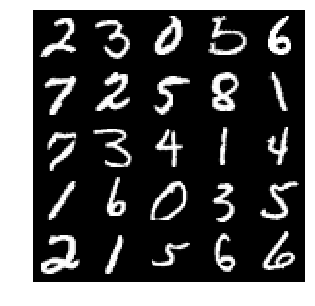

Noisy Images with noise factor of 0.5 as input


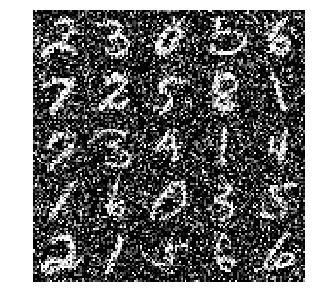

Reconstructed Images from the noisy images


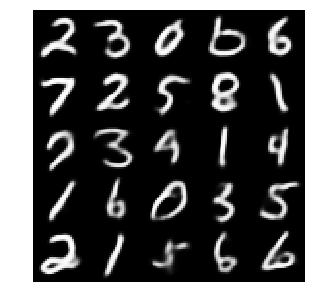

In [22]:
Test_model(batch_size=5)